In [22]:

import os

import matplotlib.pyplot as plt

import clip as clip
import wandb

wandb.login()

%reload_ext autoreload
%autoreload 2

# Data Loading

In [23]:


from text_processing import load_and_process_data

df = load_and_process_data("init")
df.info()
df = df.dropna()
df = df.rename(columns={"index": "label_index"})
df = df.reset_index()

Loading pre-processed data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             137 non-null    int64 
 1   שם התשובה ומקורו  137 non-null    object
 2   question          137 non-null    object
 3   label             132 non-null    object
 4   answer            137 non-null    object
dtypes: int64(1), object(4)
memory usage: 5.5+ KB


Text(0.5, 1.0, 'Histogram of answer length')

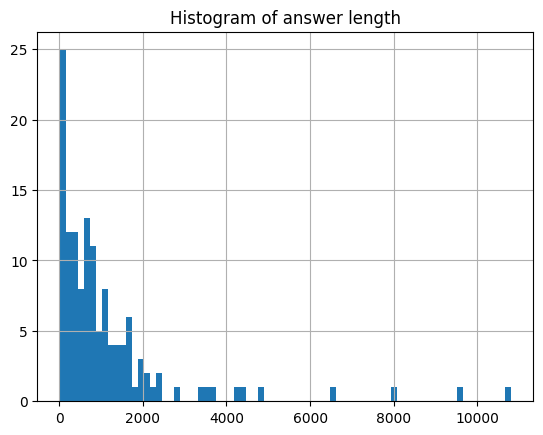

In [24]:
df["answer_length"] = df["answer"].str.split(" ").str.len()
df["answer_length"].hist(bins=75)
plt.title("Histogram of answer length")


Text(0.5, 1.0, 'Histogram of question length')

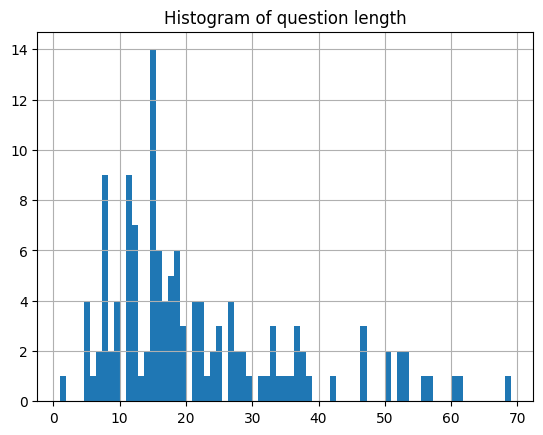

In [25]:
df["question_length"] = df["question"].str.split(" ").str.len()
df["question_length"].hist(bins=75)
plt.title("Histogram of question length")


In [26]:
df[["question_length", "answer_length"]].corr()

,question_length,answer_length
question_length,1.000000,0.056155
answer_length,0.056155,1.000000


In [27]:
import pandas as pd
import json

with open('files/train.json', 'r') as file:
    json_data = json.load(file)
q_and_a = pd.DataFrame(json_data['data'])
print(q_and_a.info())
# q_and_a.head(5)["paragraphs"][0]
q_and_a.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       3798 non-null   object
 1   source      3798 non-null   object
 2   paragraphs  3798 non-null   object
dtypes: object(3)
memory usage: 89.1+ KB
None


,title,source,paragraphs
0,מגילת העצמאות,Wikipedia,[{'context': 'לאחר שהטיוטות הראשוניות הובאו למ...
1,מדינה,Wikipedia,"[{'context': 'במהלך ההיסטוריה, ואף כיום, מתקיי..."
2,רפובליקת ויימאר,Wikipedia,[{'context': 'הממשלה הזמנית השיגה את הסכמת רוב...
3,נבחרת ישראל בכדורגל,Wikipedia,[{'context': 'ב-1 באפריל 2012 חנכה ההתאחדות לכ...
4,ליברטריאניזם,Wikipedia,[{'context': 'מבקרי הליברטריאניזם משמאל ומימין...


In [28]:


from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm  # For progress bar

berel_tokenizer = AutoTokenizer.from_pretrained("dicta-il/BEREL")
berel_model = AutoModel.from_pretrained("dicta-il/BEREL")


def simple_chunking(text, chunk_size=128, overlap=0):
    words = text.split()
    chunks = []

    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)

    return chunks


def get_berel_embeddings(texts, chunk_size=300, overlap=30):
    all_embeddings = []

    for text in tqdm(texts):
        chunked_text = simple_chunking(text, chunk_size=chunk_size, overlap=overlap)
        embedding = get_berel_embedding_from_chunked_text(chunked_text)
        all_embeddings.append(embedding)

    return np.vstack(all_embeddings)


def get_berel_embedding_from_chunked_text(texts: list):
    all_embeddings = []

    for text in texts:
        inputs = berel_tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=berel_tokenizer.model_max_length,
        )
        with torch.no_grad():
            outputs = berel_model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        all_embeddings.append(embedding)
    return np.vstack(all_embeddings).mean(axis=0)


def train(question_embeddings_plus, answer_embeddings_plus):
    wandb.finish()

    wandb.init(
        # Set the project where this run will be logged
        project="RabbanicWisdomAI",
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=f"exp-2",
        # Track hyperparameters and run metadata
        config={
            "learning_rate": 1e-4,
            "model": "ClipModel",
            "epochs": 100,
            "batch_size": 16,
            "dropout": 0.25,  # 0.25
            "latent_dim": 768,  # output dim of embedding
            "hidden_dim": 512,
            "imgdim": question_embeddings_plus.shape[1],  # input dim of image
            "ppidim": answer_embeddings_plus.shape[1],  # input dim of ppi
            "n_sample": answer_embeddings_plus.shape[0],
            "nce_w": 0,
            "clip_w": 1,
            "nce_t": 0.5,  #temp
            "unif_w": 0,
            "align_w": 0,
            "verbose": False
        },
    )
    resultsdir = f"results/exp-2"  # where to save the embeddings and model artifact
    if not os.path.exists(resultsdir):
        os.makedirs(resultsdir, exist_ok=True)
    idxs = list(range(len(answer_embeddings_plus)))
    model = clip.clip_fit_predict(
        resultsdir=resultsdir,
        index_names=idxs,
        data_ppi=answer_embeddings_plus,
        data_img=question_embeddings_plus,
        config=wandb.config,
        wandb=wandb,
    )
    wandb.finish()
    return model

Some weights of BertModel were not initialized from the model checkpoint at dicta-il/BEREL and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
import pandas as pd
import torch
from datetime import datetime

os.environ["WANDB_SILENT"] = "true"

CHUNK_SIZE = 400
OVERLAP_SIZE = 20


def get_embeddings(texts, chunk_size=CHUNK_SIZE, overlap=OVERLAP_SIZE):
    # Assuming get_berel_embeddings is defined elsewhere
    return get_berel_embeddings(texts, chunk_size=chunk_size, overlap=overlap)


def train_model(question_embeddings, answer_embeddings):
    # Assuming train function is defined elsewhere
    return train(question_embeddings, answer_embeddings)


from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment


# KNN-based evaluation using PyTorch and NumPy
def knn_score(similarity_submatrix, k):
    predictions = []
    # Perform kNN for each row and check if the row index is among the top k neighbors
    for i in range(similarity_submatrix.shape[0]):
        row = similarity_submatrix[i, :]
        top_k = np.argsort(row)[-k:]  # Get indices of the top k values (ascending order)
        if i in top_k:
            predictions.append(1)  # True prediction
        else:
            predictions.append(0)  # False prediction

    true_labels = np.ones(similarity_submatrix.shape[0])

    # Calculate accuracy score
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy, predictions


# Hungarian-based evaluation using PyTorch and NumPy
def hungarian_score(similarity_submatrix):
    # Convert similarities to costs by subtracting from 1 (because the Hungarian algorithm finds minimum cost)
    cost_matrix = 1 - similarity_submatrix

    # Perform matching using the Hungarian algorithm
    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    accuracy = (row_indices == col_indices).mean()
    return accuracy, col_indices


# Main evaluation function that includes all methods
def evaluate_model(model, question_embeddings, answer_embeddings):
    with torch.no_grad():
        q_features, a_features = model.get_embedding(
            torch.from_numpy(answer_embeddings),  # Convert to tensor
            torch.from_numpy(question_embeddings)  # Convert to tensor
        )

    # Normalize embeddings
    q_features = q_features / q_features.norm(dim=-1, keepdim=True)
    a_features = a_features / a_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity matrix using sklearn's cosine_similarity
    similarity_submatrix = cosine_similarity(q_features.cpu().numpy(), a_features.cpu().numpy())

    # KNN and Hungarian-based evaluation
    knn_acc = {}
    for k in [1, 2, 3, 5]:
        accuracy_knn, _ = knn_score(similarity_submatrix, k=k)
        knn_acc[k] = accuracy_knn
    accuracy_hungarian, _ = hungarian_score(similarity_submatrix)

    return knn_acc, accuracy_hungarian


from text_processing import generate_ext_q_and_a


def generate_qa(q_and_a, relevant_titles, num_questions):
    return generate_ext_q_and_a(q_and_a, relevant_titles, num_questions)


def run_experiment(constant_embeddings, model_original):
    q_emb_test = constant_embeddings["q_emb_test"]
    a_emb_test = constant_embeddings["a_emb_test"]

    q_emb_combined = constant_embeddings["q_emb_combined"]
    a_emb_combined = constant_embeddings["a_emb_combined"]

    print(f"training combined model with {q_emb_combined.shape=}")
    model_combined = train_model(q_emb_combined, a_emb_combined)

    accuracy_knn_origin, accuracy_hungarian_origin = evaluate_model(model_original, q_emb_test,
                                                                    a_emb_test)
    accuracy_knn_combined, accuracy_hungarian_combined = evaluate_model(model_combined,
                                                                        q_emb_test,
                                                                        a_emb_test)
    accuracy_knn_origin = {f"accuracy_no_q_a_knn={k}": acc for k, acc in accuracy_knn_origin.items()}
    accuracy_knn_combined = {f"accuracy_plus_q_a_knn={k}": acc for k, acc in accuracy_knn_combined.items()}

    res = {
        "accuracy_plus_q_a_hungarian": accuracy_hungarian_combined,
        "accuracy_no_q_a_hungarian": accuracy_hungarian_origin,

    }
    res.update(accuracy_knn_origin)
    res.update(accuracy_knn_combined)

    return res





In [30]:
questions = df["question"].to_list()
answers = df["answer"].to_list()

relevant_titles = ['שבת שירה', 'בראשית', 'רש"י', 'ברכת המזון', 'טעמי המקרא', 'שבע מצוות בני נח', 'ברית המילה', 'תנ"ך',
                   'מרד בר כוכבא', 'יציאת מצרים', 'פורים', 'תורה', 'רמב"ם', 'שבת',
                   'יצחק כדורי', 'תפילת הדרך', 'יוסף קארו', 'הלכה', 'שולחן ערוך', 'היסטוריה של עם ישראל',
                   'המבול', 'אברהם', 'ברית מילה', 'ברכות השחר', 'ירושלים', 'גירוש ספרד', 'אברהם אבן עזרא', 'כשרות',
                   'גיור',
                   'מזוזה', 'מעמד האישה ביהדות', 'תהילים', 'עשרת הדיברות',
                   'ברכת הגומל', 'אלוהים', 'אבלות (יהדות)', 'מגילת קהלת',
                   'בית המקדש הראשון', 'מגדל בבל', 'תנועת החסידות', 'גלות בבל', 'מרדכי בן-פורת',
                   'תחיית הלשון העברית', 'יהדות מרוקו', 'מנחם מנדל שניאורסון', 'בית המקדש', 'אוריה החתי']

q_and_a_processed = generate_qa(q_and_a, relevant_titles, int(df["answer_length"].median()))
questions_qa = q_and_a_processed["questions_q_a"].to_list()
answers_qa = q_and_a_processed["answers_q_a"].to_list()
import pickle

embeddings_path = "embeddings.pkl"
if os.path.exists(embeddings_path):
    with open(embeddings_path, "rb") as f:
        all_embeddings = pickle.load(f)
        print(f"Loaded the embeddings: {list(all_embeddings.keys())}")
else:
    questions_embeddings = get_embeddings(questions)
    answers_embeddings = get_embeddings(answers)
    questions_qa_embeddings = get_embeddings(questions_qa)
    answers_qa_embeddings = get_embeddings(answers_qa)
    all_embeddings = {"questions_embeddings": questions_embeddings, "answers_embeddings": answers_embeddings,
                      "questions_qa_embeddings": questions_qa_embeddings,
                      "answers_qa_embeddings": answers_qa_embeddings}
    with open(embeddings_path, "wb") as f:
        pickle.dump(all_embeddings, f)


100%|██████████| 423/423 [00:59<00:00,  7.10it/s]


In [33]:
for i, row in q_and_a_processed.head(3).iterrows():
    print(row["questions_q_a"])
    print(row["answers_q_a"])
    print()

כמה צדיקים היה צריך אברהם למצוא על מנת שאלוהים יחוס על סדום?
 המסורת, בעת שישב בכניסה לסוכתו באלוני ממרא ניגלו לאברהם שלושה מבקרים. אברהם בירך אותם והציע לשטוף רגליהם ואת לחם ביתו. הוא אירח אותם תחת עץ ואכל עמם, כאשר אחד מן האורחים אמר לאברהם שבעוד שנה לשרה יהיה בן זכר. שרה שמעה זאת מפתח הסוכה וצחקה כי לא ייתכן שבגילה יכולה להרות. האורח שאל מה פשר הצחוק של שרה, כי בעזרת האלוהים אין זה בלתי אפשרי שתהרה גם בגילה, מה שהבהיל את שרה. לאחר הארוחה, שלושת האורחים עלו לפסגה סמוכה וצפו על הערים במישור, תוך שהם דנים על גורל סדום ועמורה, כי "פשעיהם היו רבים". בשלב זה, עזבו שניים מן האורחים את אברהם בדרכם לסדום ואילו אברהם פנה אל האלוהים בבקשה לחוס על העיר, כי אחיינו לוט שהה בה. לאחר תפילתו, אורחיו של אברהם הגיע לסדום בחיפוש אחר "עשרה צדיקים", אשר מציאתם הייתה מביאה את אלוהים לחוס על תושבי העיר. לוט אירח אותם בביתו. כשהמון זועם דרש את האורחים, לוט סירב ואף הציע את בנותיו הבתולות במקום, אך ההמון המשיך ורצה לשבור את דלת ביתו של לוט - מה שעורר זעם של האלוהים. למחרת בבוקר, כשהיה ברור כי אין עשרה צדיקים

In [34]:
q_and_a_processed.shape[0]

423

In [35]:

from utils import split_data
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"


def main(df, q_and_a_processed, all_embeddings, num_qas, relevant_titles, iter=5, random_split=False):
    results = []
    q_and_a_processed_filtered = q_and_a_processed[q_and_a_processed["title"].isin(relevant_titles)]
    for i in range(iter):
        print(f"{datetime.now()} - {i=}")
        # set_seed_globally(i)
        df_train, df_test = split_data(df, random_split)

        q_emb_train = all_embeddings["questions_embeddings"][df_train.index]
        a_emb_train = all_embeddings["answers_embeddings"][df_train.index]
        q_emb_test = all_embeddings["questions_embeddings"][df_test.index]
        a_emb_test = all_embeddings["answers_embeddings"][df_test.index]
        constant_embeddings = {"q_emb_train": q_emb_train, "a_emb_train": a_emb_train, "q_emb_test": q_emb_test,
                               "a_emb_test": a_emb_test}
        print(f"training original model with {q_emb_train.shape=}")
        model_original = train_model(q_emb_train, a_emb_train)

        for num_qa in num_qas:

            if num_qa > q_and_a_processed_filtered.shape[0]:
                print(f"{num_qa=} is larger than {q_and_a_processed_filtered.shape}")
                raise
            q_and_a_processed_tmp = q_and_a_processed_filtered.sample(num_qa)
            q_emb_external = all_embeddings["questions_qa_embeddings"][q_and_a_processed_tmp.index]
            a_emb_external = all_embeddings["answers_qa_embeddings"][q_and_a_processed_tmp.index]
            q_emb_combined = np.concatenate([q_emb_train, q_emb_external])
            a_emb_combined = np.concatenate([a_emb_train, a_emb_external])
            constant_embeddings.update({"q_emb_combined": q_emb_combined, "a_emb_combined": a_emb_combined})
            print(f"{datetime.now()} - {num_qa=}")
            result = run_experiment(constant_embeddings, model_original)

            result.update({"iter": i, "appended_q_a": q_emb_external.shape[0], "num_qa": num_qa})
            results.append(result)
            print(result)

    return results



In [37]:
num_qas = [5, 10, 30, 60, 90, 120, 240, 400]
import time

start = time.time()
results_random_split = main(df, q_and_a_processed, all_embeddings, num_qas, relevant_titles, iter=40,
                            random_split=False)
results_random_split_df = pd.DataFrame(results_random_split)
results_random_split_df.to_csv("results/results_from_clip_v2.csv", index=False)
end = time.time()
print(f"finished with {end - start}/60")

2024-09-18 22:13:38.991935 - i=0
training original model with q_emb_train.shape=(105, 768)


Alignment,▇█▇▆▆▅▄▅▃▄▃▄▁▂▁▁
Clip,▇█▇▆▆▅▄▅▃▃▃▄▁▂▁▂
Epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
Loss,▇█▇▆▆▅▄▅▃▃▃▄▁▂▁▂
NCE,▇█▇▆▆▅▄▅▃▄▃▄▁▂▁▁
Temperatue,▁▂▄▅▆▇▇█████▇▇▅▄
Uniform,▂█▇▆▅▄▁▂▆▄▆▇▆▅▄▇
Alignment,1.93004
Clip,2.37187
Epoch,15
Loss,2.37187


Alignment,██▇█▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁
NCE,██▇█▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▁▂▂▃▂▂▂▃▁▂▄▁▁▃▁▁▁▄▄▅▄▃▆▃▅▆▆▅▆▆▆▅▆▇█▇
Alignment,1.49444
Clip,0.57145
Epoch,99
Loss,0.57145


2024-09-18 22:14:07.434197 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▇▆▆▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁
Clip,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▂▂▃▂▁▂▂▂▃▃▁▂▃▂▂▂▃▄▃▃▃▂▄▂▃▄▅▄▅▃▄▅▅▅▆▆▆▆█
Alignment,1.45243
Clip,0.54655
Epoch,99
Loss,0.54655


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5185185185185185, 'iter': 0, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:14:32.048896 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▂▃▂▃▂▂▂▁▁▂▁▁
Clip,█▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▁▁▁▁▁
NCE,█▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▃▂▂▂▁▁▂▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▂▂▃▄▄▂▁▂▄▅▄▆▄▅▃▂█▄▄▁▆▅▆▅▄▆▆▅▇▃▃▄▄▄▅▄▆▆▅
Alignment,1.66219
Clip,0.971
Epoch,99
Loss,0.971


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 0, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:14:58.597094 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▄▂▃▅▄▄▅▅▅▅▅▆▆▇▇▅▆▆▅▅▇▆▇▆▅█▆▆▅▇▇█▆█▇▇▇
Alignment,1.41412
Clip,0.47975
Epoch,99
Loss,0.47975


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 0, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:15:22.508584 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▅▅▆▆█▇▇▇▆▇▇▇▇▆▆▇▅▆▇▅▆▆▆▆▇▆▇▆▆▅▆▇▆
Alignment,1.415
Clip,0.4665
Epoch,99
Loss,0.4665


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 0, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:15:52.310048 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▅▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
NCE,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▅▆▆▆▆▇▆▆▇▇█▇████▇▇▆▆▆▆▆▆▆▇▇▆▆▆▆▆▅▆▆
Alignment,1.48535
Clip,0.58617
Epoch,99
Loss,0.58617


{'accuracy_plus_q_a_hungarian': 0.18518518518518517, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 0, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:16:34.981853 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▆▆▇▇▇▇█▇▇▆▇▇▇▆▆▆▆▆▆▇▇▆▅▆▆▅▅▆▆▆▇▆▆▇▆
Alignment,1.33317
Clip,0.32122
Epoch,99
Loss,0.32122


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 0, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:17:09.784363 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▅▅▆▆▅▅▆▆▆▆▆▆▆▆▇▇▆▆▇▇▆▇▇▇▇▇▇▇█▇▇███▇█
Alignment,1.26684
Clip,0.25785
Epoch,99
Loss,0.25785


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 0, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:18:06.506164 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▄▅▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇█▇▇███▇█████████
Alignment,1.21398
Clip,0.19367
Epoch,99
Loss,0.19367


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 0, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:19:14.664830 - i=1
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▂▄▁▃▅▃▂▂▂▂▂▃▅▃▅▂▃▁▁▄▃▃▃▂▂▅▄▃▅▅▃▆█▆▅▇▅█▇
Alignment,1.47461
Clip,0.48385
Epoch,99
Loss,0.48385


2024-09-18 22:19:35.131498 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▆▆▆▆▆▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▄▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▄▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▅▃▂▃▅▃▅▂▅▃▄▃▂▆▃▃▄▂▃▃▃▂▄▃▄▃▃▄▅▇▅▆▇▇█▆▇█▇
Alignment,1.46898
Clip,0.51836
Epoch,99
Loss,0.51836


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 1, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:19:53.591101 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Clip,█▇▇▇▇▇▇▆▅▆▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▇▇▆▅▆▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
NCE,█▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▄▂▃▂▄▅▄▄▄▅▅▃▇▄▄▅▆▃▄▆▄▃█▁▄█▄▄▃▇▅▂▃▃▆▇▆▃▆█
Alignment,1.6591
Clip,0.98359
Epoch,99
Loss,0.98359


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 1, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:20:12.207468 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Clip,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▂▂▃▄▄▅▅▆▇▆▆▆▆▇▆▆▆▇▆▆▆▇▅▇▇▇▇▇▆▇▇▆███▇█▇
Alignment,1.4256
Clip,0.45608
Epoch,99
Loss,0.45608


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 1, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:20:32.640008 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▅▆▆▇▆█▇▇███▇▇▇▇▇█▇▆▇▇█▆▇▇▆▇▇▇▇▇█▇█▆
Alignment,1.42133
Clip,0.47744
Epoch,99
Loss,0.47744


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 1, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:20:55.261774 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▁▂▁▁▁
Clip,██▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▃▅▆▆▆█▇█▇▇█▇▇█▇▇▇▆▇█▆▆▆▆▆▅▇▆▆▆▆▇▆▆▆▇
Alignment,1.46092
Clip,0.54923
Epoch,99
Loss,0.54923


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 1, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:21:22.820140 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,██▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▆▇▇▇█▆▇█▇▇▇█▇▆█▇▇▆▇▆▇▇▆▆▇▆▇▇▇▇█▇▆▇
Alignment,1.3315
Clip,0.35133
Epoch,99
Loss,0.35133


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 1, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:21:52.730732 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▄▅▅▆▆▆▆▆▆▇▇█▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██
Alignment,1.27117
Clip,0.2802
Epoch,99
Loss,0.2802


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 1, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:22:37.641807 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇██
Alignment,1.22719
Clip,0.23754
Epoch,99
Loss,0.23754


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 1, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:23:34.306376 - i=2
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,███▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▆▂▂▄▂▃▅▄▃▄▃▃▃▃▄▃▁▂▂▃▃▃▄▃▃▃▃▃▃▅▄▃▇▆▅▇▆▆█▇
Alignment,1.49704
Clip,0.56961
Epoch,99
Loss,0.56961


2024-09-18 22:23:52.884031 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▂▂▂▂▁▃▄▃▁▂▃▁▃▂▃▃▂▃▄▂▃▃▅▃▃▄▅▅▅▆▅▆▆▆▆▅███
Alignment,1.44983
Clip,0.5016
Epoch,99
Loss,0.5016


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 2, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:24:10.476302 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▆▆▆▇▆▆▆▆▆▅▅▅▄▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▁▁▂▁▁
Clip,█▇▇▇▇▆▆▆▆▅▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▆▆▆▆▅▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁
NCE,██▇▇▇▆▆▆▇▆▆▆▆▆▅▅▅▄▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▁▁▂▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▁▂▃▄▄▃▇▃▃▄▅▄▂█▄▃▂▆▃▅▂▅██▄▄▅▅▃▅▄▄▂▅▃▄▄▆▃
Alignment,1.65394
Clip,0.97018
Epoch,99
Loss,0.97018


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 2, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:24:31.980342 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,███▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▃▃▄▄▄▅▄▅▆▅▅▆▆▆▅▅▅▆▅▇▅██▇▆▆▅▇▅▇▇▇▇▆█▆
Alignment,1.43478
Clip,0.46981
Epoch,99
Loss,0.46981


{'accuracy_plus_q_a_hungarian': 0.18518518518518517, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 2, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:24:56.454978 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▄▅▆▆▇▇▇▇▇▆▆▆▇▆▇▆█▆▆▆▇▇▇▆▆▆▇▇▆▆▇▆▇▇▆
Alignment,1.40433
Clip,0.37982
Epoch,99
Loss,0.37982


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.5925925925925926, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 2, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:25:21.026678 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▁▂▂▄▃▄▅▆▅▇▇█▆▇▇▇█▇▆▇▇█▇▇▇▆▆▆▇▆▆▇▆▇▆▆▇▇▇
Alignment,1.47927
Clip,0.59392
Epoch,99
Loss,0.59392


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.4074074074074074, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 2, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:25:46.509174 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▄▅▇▆▇▇█▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇████▇▇
Alignment,1.30758
Clip,0.31576
Epoch,99
Loss,0.31576


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 2, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:26:14.385268 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▄▅▅▅▆▅▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇█▇▇▇███▇▇████▇█
Alignment,1.25368
Clip,0.2275
Epoch,99
Loss,0.2275


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 2, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:26:58.030426 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇██▇▇▇██
Alignment,1.21882
Clip,0.22874
Epoch,99
Loss,0.22874


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 2, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:27:53.611189 - i=3
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▆▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,██▇█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▃▃▄▄▃▄▂▃▃▂▃▄▁▂▃▂▁▄▃▂▂▄▄▃▃▄▅▇▄▃▄▇▆▆▇▅▇▇█▇
Alignment,1.50363
Clip,0.56554
Epoch,99
Loss,0.56554


2024-09-18 22:28:10.141101 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Clip,███▇▇▇▆▇▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▇▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▃▁▂▃▁▂▃▁▂▁▂▃▃▁▃▂▃▄▂▂▃▃▃▃▃▅▄▃▄▃▆▄▅█▅▅█▅▇
Alignment,1.48065
Clip,0.57411
Epoch,99
Loss,0.57411


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.5555555555555556, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 3, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:28:26.635551 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇█▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▁▂▁▁▁
Clip,█▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇█▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▁▁▁▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▁▄▁▂▃▃▄▂▃▄▃▅▆▁▃▃▄▄▆▅▃▃▆▄▅▄▄▆▄▄█▆▅▆▆▆▄▃▅
Alignment,1.64307
Clip,0.89677
Epoch,99
Loss,0.89677


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.5555555555555556, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 3, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:28:44.326114 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▂▄▄▄▃▄▅▄▄▆▄▄▅▅▅▅▅▆▆▆▅▆▆▆▆▅▆▇█▆▆▆▇▇▆▆
Alignment,1.43382
Clip,0.47088
Epoch,99
Loss,0.47088


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.5555555555555556, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 3, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:29:04.115589 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Clip,█▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▄▆▇▇▇▇███▇▆▇▇█▇███▇▆▇▆▇▇▆██▇▇█▇▆▇▇▇
Alignment,1.40633
Clip,0.43978
Epoch,99
Loss,0.43978


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.5555555555555556, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 3, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:29:26.630444 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▆▆▇▆▆▇▇█▆▇▇██▆▆▇▆▆▆█▆▆▆▆▆▆▆▆▆▅▆▅▆
Alignment,1.45801
Clip,0.53304
Epoch,99
Loss,0.53304


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.5555555555555556, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 3, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:29:53.017019 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▆▇██▇███▇▇▇▇▇▇▇▆▆▇▆▆▇▇▇▇▇▇▇█▇▇▆▇█▇
Alignment,1.32656
Clip,0.36447
Epoch,99
Loss,0.36447


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.5555555555555556, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 3, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:30:24.858574 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▇▆▆▆▆▆▇▇▇▇██▇▇▇▇▇▇█▇▇▇█▇██▇▇█████▇
Alignment,1.2877
Clip,0.28325
Epoch,99
Loss,0.28325


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.5555555555555556, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 3, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:31:15.554914 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▃▃▃▄▄▄▅▅▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇███
Alignment,1.2234
Clip,0.23345
Epoch,99
Loss,0.23345


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.5555555555555556, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 3, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:32:26.937434 - i=4
training original model with q_emb_train.shape=(105, 768)


Alignment,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,███▇█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▃▂▃▄▂▂▁▁▃▄▃▂▂▁▂▂▂▂▃▂▂▂▃▂▄▄▅▄▅▅▅▅▅▅▆▆▆▅█
Alignment,1.4883
Clip,0.52641
Epoch,99
Loss,0.52641


2024-09-18 22:32:47.438528 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▂▂▂▂▂▂▁▂▂▁▁
Clip,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▂▂▂▁▂▄▁▁▃▅▃▃▃▃▃▃▂▄▃▁▃▃▂▄▄▄▃▄▅▆▄▇▆▇▆▇▇▇█
Alignment,1.45228
Clip,0.50731
Epoch,99
Loss,0.50731


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 4, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:33:04.928050 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁
Clip,██▇▇▆▇▆▆▆▅▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▇▆▆▆▅▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
NCE,███▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▄▆▄▄▄▂▇▆▁▃▃▂▄▃▆▄▄▆█▇▃█▂▅▂▄▇▇▁█▇▅▂███▄▃▆▄
Alignment,1.64393
Clip,0.87106
Epoch,99
Loss,0.87106


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 4, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:33:24.751107 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▁▂▃▂▄▄▄▅▅▅▄▄▆▆▅▆▇▆▆▅▅▇▆▇▇▅▇▇▇▆▆▇▆▆▇█▇▆
Alignment,1.42687
Clip,0.45813
Epoch,99
Loss,0.45813


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 4, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:33:46.382218 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▄▃▄▆▆▆▆▇▇▆▆▆▆▆██▇▆▆▆▆▆▅▆▆▇▆▆▆▆▆▇▆▅█▇▆
Alignment,1.4175
Clip,0.42498
Epoch,99
Loss,0.42498


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 4, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:34:15.924577 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,█▇▇▇▆▆▅▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▂▂▃▄▅▆▆▇▆▇█▇▇███▇█▆██▆▇▇▇▆▇▆▆▆▆▆▅▇▆▆▆▆▅
Alignment,1.47591
Clip,0.54771
Epoch,99
Loss,0.54771


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 4, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:34:49.552372 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▇▇▇▇▇█▇▇▆▇▇▆▇▆▆▇▇▆▇▆▆▆▆▆▇▆▆▆█▇▆▇▇▆
Alignment,1.33983
Clip,0.34482
Epoch,99
Loss,0.34482


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 4, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:35:25.153431 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▆▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇█▇██▇█▇██████▇██
Alignment,1.24946
Clip,0.23351
Epoch,99
Loss,0.23351


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 4, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:37:07.983774 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▃▃▄▄▅▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇█▇█
Alignment,1.22443
Clip,0.20921
Epoch,99
Loss,0.20921


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 4, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:38:10.406550 - i=5
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
Clip,███▇▇▇▇▇▆▆▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▇▆▆▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▃▃▂▃▃▄▁▂▂▄▃▂▁▃▄▄▃▁▂▂▃▂▁▂▆▄▄▂▄▄▄▅▅▄▄▅▅▆██
Alignment,1.49246
Clip,0.52278
Epoch,99
Loss,0.52278


2024-09-18 22:38:28.857549 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▄▃▅▃▃▂▃▃▄▂▃▂▂▄▃▃▄▂▅▄▄▂▄▃▂▁▄▆▅▅▆▄▆▄▅▇▆█▇█
Alignment,1.47373
Clip,0.52676
Epoch,99
Loss,0.52676


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 5, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:38:49.409040 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▆▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▄▄▃▃▃▃▂▂▂▂▂▁▂▁▁
Clip,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▂▁▁
NCE,██▇▇▇▇▆▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▄▄▃▃▃▃▂▂▂▂▂▁▂▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▂▂▂▁▃▃▃▁▂▂▃▃▁▃▃▅▃▂▁▅▂▃▄▃▃▂▂▂▃▃▃▂▃▅▃▃█▃▃▃
Alignment,1.63131
Clip,0.86528
Epoch,99
Loss,0.86528


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7777777777777778, 'iter': 5, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:39:11.315612 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,███▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▁▂▁▁
Clip,█▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,███▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▁▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▁▁▂▂▄▃▄▃▄▅▄▄▅▅▅▅▅▄▅▄▄▇▆▆▅▅▅▆▄▅▆▆▇██▆▆▆
Alignment,1.40046
Clip,0.38027
Epoch,99
Loss,0.38027


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 5, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:39:37.732143 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▆▅▆▆▆▇▇▆▇▇▇██▆▆▆▇██▇█▇▇▇▆▇▇▇▆█▇█▇▇▇
Alignment,1.41387
Clip,0.46775
Epoch,99
Loss,0.46775


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 5, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:40:03.002269 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▁▃▃▄▅▅▆▆▆▆▆▆▇▇█▇▇▆██▇▇▆▇▆▆▅▇▇▆▇▇▆▆▆▆▅▇▆
Alignment,1.48293
Clip,0.60188
Epoch,99
Loss,0.60188


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 5, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:40:34.086878 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,█████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▆▅▇▇▇█▇██▇▇▇▇▇▇▇▇▇▇▆▆▇▇▆▇▆▇▆▇▇▇▇▆▇▇▆
Alignment,1.32252
Clip,0.32242
Epoch,99
Loss,0.32242


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.4444444444444444, 'accuracy_plus_q_a_knn=2': 0.6296296296296297, 'accuracy_plus_q_a_knn=3': 0.6666666666666666, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 5, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:41:26.942788 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▅▅▆▆▆▆▆▆▇▇▇▆▆▆▇▆▇▆▇▇▇▇▇█▇▇▇▇███▇█▇█
Alignment,1.27133
Clip,0.27304
Epoch,99
Loss,0.27304


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 5, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:42:14.709516 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█▇▇█▇█▇█▇▇█████████
Alignment,1.22386
Clip,0.21732
Epoch,99
Loss,0.21732


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.5185185185185185, 'iter': 5, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:43:22.785729 - i=6
training original model with q_emb_train.shape=(105, 768)


Alignment,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Clip,███▇▇▇▆▇▆▆▆▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▇▆▆▆▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▂▂▁▁▄▅▃▃▄▅▂▂▂▃▄▄▃▄▄▃▃▆▄▄▄▃▂▄▅▇▄▅▇▆▅▅▆▇██
Alignment,1.48678
Clip,0.57543
Epoch,99
Loss,0.57543


2024-09-18 22:43:44.330199 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Clip,███▇▇▇▇▆▆▆▅▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▅▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▂▂▄▁▂▂▂▃▃▃▃▂▃▄▁▂▃▃▃▂▃▃▄▃▄▄▆▅▅▅▆█▆▄▇▇▆▇▇
Alignment,1.45616
Clip,0.46789
Epoch,99
Loss,0.46789


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 6, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:44:04.164823 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▆▇▆▆▆▅▅▅▄▅▄▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▇▆▆▆▅▅▅▄▅▄▄▄▄▃▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
NCE,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▂▃▆▂▁▆▄▄▃▂▂▄▁▃▄▄▅▇▃▅▆▅▅▄▆▇▄▇▅▇▇▆▃▅▄█▇▆▄▅
Alignment,1.62196
Clip,0.83412
Epoch,99
Loss,0.83412


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 6, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:44:25.650437 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▁▃▃▄▆▅▅▅▆▅▆▅▆▆▇▇▅▆▄██▆▇▆▅▇▅▆▇▆▆▆▆▆▆█▇▇
Alignment,1.41976
Clip,0.46246
Epoch,99
Loss,0.46246


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 6, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:44:50.173510 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▄▅▅▇▆▅▇▆▆▇▇█▆▆▇▅▆▆▆▇▆▆▅▇▆▅▅▆▅▅▆▆▅▆▆█
Alignment,1.40169
Clip,0.41429
Epoch,99
Loss,0.41429


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 6, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:45:17.749480 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▆▅▆▆▇▇▆██▇▇▇▇▇▇▇▆▇▆▆▇▆▆▇▅▆▇▆▆▅▅▇▆▅▆
Alignment,1.48137
Clip,0.50739
Epoch,99
Loss,0.50739


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 6, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:45:53.420887 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▅▇▇▇▇▇▆▇▇▇▆▆▆▇█▇▇▆▆▇█▇▇▇▇▇▆▆▇▇██▇█▇
Alignment,1.30801
Clip,0.2952
Epoch,99
Loss,0.2952


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 6, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:46:28.080524 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇█▇▇▇▇▇▆▆█▇▇█▇█▇▇▇▇██
Alignment,1.24745
Clip,0.24347
Epoch,99
Loss,0.24347


{'accuracy_plus_q_a_hungarian': 0.18518518518518517, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 6, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:47:20.640543 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇██▇▇▇█▇█▇█
Alignment,1.21655
Clip,0.2104
Epoch,99
Loss,0.2104


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 6, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:48:24.768196 - i=7
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▁▂▂▂▁
Clip,███▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▁▂▂▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▃▁▂▂▂▂▁▂▃▂▃▂▂▂▃▄▁▂▃▃▂▂▄▃▃▃▃▄▃▅▄▃▆▇▆█▆▆▆█
Alignment,1.47313
Clip,0.53672
Epoch,99
Loss,0.53672


2024-09-18 22:48:45.306540 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▂▂▂▂▁▃▁▂▂▂▂▃▂▂▃▃▃▃▄▂▂▂▃▄▅▅▅▅▅▅▄▅▆▇█▇██▆
Alignment,1.45617
Clip,0.54395
Epoch,99
Loss,0.54395


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 7, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:49:09.345434 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇█▇▇▇▆▆▆▆▆▅▅▅▅▄▅▅▅▄▄▄▄▃▃▃▄▃▃▃▂▂▂▂▂▂▁▁▁
Clip,██▇█▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇█▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
NCE,██▇█▇▇▇▆▆▆▆▆▅▅▅▅▄▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▇▅▃▁▃▂▄▃▅▆▂▅▄▆▅▇▆▄▆▃█▆▅▇▅▅▇▄▇▆▅▅▄▆▆▅▆▅█▇
Alignment,1.64117
Clip,0.89536
Epoch,99
Loss,0.89536


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 7, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:49:32.176578 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▁▃▂▃▄▄▃▆▅▅▆▆▆▆█▆▆▆▅▆▇▇▆▇▅▇▇▆▆▆▇▆▆███▇▆
Alignment,1.44281
Clip,0.45632
Epoch,99
Loss,0.45632


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 7, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:50:03.701747 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▆▆▅▇▇▆▇▆▇▇█▇▇██▇▇▇█▆▇▇▆▆█▆▅▇▆▇▇█▆▇▇
Alignment,1.3952
Clip,0.37441
Epoch,99
Loss,0.37441


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 7, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:50:33.603660 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▅▆▆▇▇▇▇█▇▇▇█▇▆▇█▇█▆▆▆▆▇▆▆▇▆▆▅▅▆▇▆▆▆
Alignment,1.44685
Clip,0.48828
Epoch,99
Loss,0.48828


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 7, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:51:05.167587 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▇▇▇█▇▇▇█▇▇▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▆▆
Alignment,1.32928
Clip,0.37759
Epoch,99
Loss,0.37759


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 7, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:51:39.762762 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▆▆▇▆▆▆▇▆▇▇▇▇█▇▇▇▇▇▆▇█▇▇▇█▆▇▇▇████
Alignment,1.25702
Clip,0.25414
Epoch,99
Loss,0.25414


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 7, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:52:27.629021 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▆▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇█
Alignment,1.22033
Clip,0.2429
Epoch,99
Loss,0.2429


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 7, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:53:38.731991 - i=8
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▁▁▂▁▁
Clip,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▂▁▂▄▃▅▄▃▂▄▃▁▂▃▄▃▃▁▃▂▅▄▅▃▄▄▃▅▄█▅▆▆▇▆█▆
Alignment,1.49736
Clip,0.54568
Epoch,99
Loss,0.54568


2024-09-18 22:54:01.417415 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,███▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▃▂▅▃▃▄▂▂▄▂▃▁▂▂▄▄▃▄▃▅▄▃▄▄▅▄▄▅▅▇▅▆▆█▆█▇▆█
Alignment,1.46307
Clip,0.54717
Epoch,99
Loss,0.54717


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 8, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:54:19.926385 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▂▃▃▂▂▂▁▂▁▁▂
Clip,███▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▂
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▂
NCE,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▁▂▁▁▂
Temperatue,███████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Uniform,▂▂▃▃▁▃▃▃▃▄▃▅▇▅▃▅▄█▃▂▄▁▆▆▄▆▄▃▆▅▅▆▅▅▆▅▄▄▅▄
Alignment,1.69169
Clip,1.12446
Epoch,99
Loss,1.12446


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 8, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:54:40.610206 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▃▃▄▅▅▆▆▅▅▆▅▆▇▅▅▆▅▄▅▆▅▆▅▇▆▆▆█▆▇█▇▇▆█▆
Alignment,1.42556
Clip,0.44813
Epoch,99
Loss,0.44813


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 8, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:55:00.130292 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▅▅▆▆▇▇██▇█▇▇▇███▆▇▇▆▆▇▆▆▆▆▆▆▆▇▅▅▆▆▆▅
Alignment,1.42846
Clip,0.42258
Epoch,99
Loss,0.42258


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 8, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:55:24.817570 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▅▆▆▆█▇█▇███▇▇▇█▇▇██▇▆▆▆▇▆▇▆▆▆▆▆▆▇▆▆
Alignment,1.46329
Clip,0.51099
Epoch,99
Loss,0.51099


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 8, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:55:54.408297 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▆▆▆▇▇█▇▇▇▇▇▇▇█▇▆▇▆▇▇▆▇▆▆▇▇▆▇▇▆▇▆▇▇█▇
Alignment,1.35123
Clip,0.40323
Epoch,99
Loss,0.40323


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 8, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 22:56:22.629867 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇███
Alignment,1.24323
Clip,0.25214
Epoch,99
Loss,0.25214


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 8, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 22:57:02.484643 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇█▇▇█▇▇███▇██████
Alignment,1.21381
Clip,0.19851
Epoch,99
Loss,0.19851


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 8, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 22:57:57.172682 - i=9
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Clip,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▄▄▃▃▄▃▂▂▄▃▄▃▃▃▄▃▁▃▂▃▃▂▄▃▃▁▃▃▃▄▆▄▅▄▇█▆▅▇▇
Alignment,1.50614
Clip,0.58546
Epoch,99
Loss,0.58546


2024-09-18 22:58:13.663038 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▃▄▄▃▃▁▄▂▃▂▂▃▃▂▃▃▃▄▄▃▂▂▅▃▄▄▄▄▆▅▄▄▆▆▆▆▅▆█
Alignment,1.44961
Clip,0.48652
Epoch,99
Loss,0.48652


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 9, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 22:58:31.316835 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▂▃▂▂▃▂▂▂▁▂▁▁
Clip,█▇▇▆▇▆▆▆▅▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▇▆▆▆▅▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,█▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▂▃▂▂▃▂▁▂▁▂▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▄▃▅▆▄▅▄▄▅▂▂▂▅▇▅▅▅▅▅▅▅▆█▄▄▆▅▃▄▅▅▆▅▅▆▆▅▆▂
Alignment,1.65226
Clip,0.94286
Epoch,99
Loss,0.94286


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 9, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 22:58:48.978101 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▂▁▂▃▅▄▅▇▄▇▅▆▆▅▆▆▄▆▆▅▇▅▆▅▅▆▆▆▇▇▅▇▇▇▆▅██
Alignment,1.42469
Clip,0.45303
Epoch,99
Loss,0.45303


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 9, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 22:59:09.765069 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▃▃▄▅▅▇▅▆▆▇▆█▆▇▆▆▆▇▆▆▇▇▆▇▇▆▇▆▅▆▇▅▆▆▆▆▆▆
Alignment,1.41474
Clip,0.40961
Epoch,99
Loss,0.40961


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 9, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 22:59:32.584668 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▄▅▆▇▆▇▇▆▆▆▇▆██▇▇█▇▆▇▇▇▆▆▆▆▆▆▇▆▆▆▆▆▆
Alignment,1.45298
Clip,0.50147
Epoch,99
Loss,0.50147


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 9, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 22:59:58.230088 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▆▆▆▇██████▇▇▇▇█▇█▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇█▇
Alignment,1.32507
Clip,0.32113
Epoch,99
Loss,0.32113


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 9, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:00:26.968302 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▅▅▆▆▆▆▆▇▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████▇███▇
Alignment,1.26898
Clip,0.25194
Epoch,99
Loss,0.25194


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 9, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:01:05.847712 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▂▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████▇▇█
Alignment,1.22605
Clip,0.21139
Epoch,99
Loss,0.21139


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 9, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:01:57.876859 - i=10
training original model with q_emb_train.shape=(105, 768)


Alignment,██▇█▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇█▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▅▅▅▆▆▄▆▆▃▄▃▂▆▄▃▃▄▄▅▄▄▄▄▆▅▅▅▅▆▆▆▇▆▆▅█▇▇█
Alignment,1.50004
Clip,0.52109
Epoch,99
Loss,0.52109


2024-09-18 23:02:14.751312 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▄▃▁▅▅▃▃▃▃▄▁▃▂▃▄▄▂▃▃▄▂▄▅▄▄▄▄▅▄▃▅▆▆▆▇▆▆█▇█
Alignment,1.45633
Clip,0.5077
Epoch,99
Loss,0.5077


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.8148148148148148, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 10, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:02:31.982102 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▁▂▁▁
Clip,██▇▇▇▇▇▇▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▇▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▁▂▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▄▄▅▁▅▄▅▅▅▃▄▄▅▄▄▃▅▄▄▆▅▅▅▄▄█▃▆▄▄▃▄▅▆▆▃▄▄▆█
Alignment,1.65325
Clip,0.92421
Epoch,99
Loss,0.92421


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.8148148148148148, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 10, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:02:49.931495 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁
Clip,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▂▄▄▄▄▅▅▅▆▅▇▅▄▇▇▆▇▇▆▇▇▆▇█▇▇▆▆▅▆▇▇▆▇██
Alignment,1.4127
Clip,0.40472
Epoch,99
Loss,0.40472


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.8148148148148148, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 10, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:03:09.889757 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▄▅▅▆▆▇▇▇▇▇█▇▆▆▅▆▇▅▆▆▆▅▆▅▅▅▇▇▅▅▆▆▆▇▅
Alignment,1.41589
Clip,0.44515
Epoch,99
Loss,0.44515


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.8148148148148148, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 10, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:03:32.509626 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▅▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▃▅▅▅▇▆▆▆█▇█▇▇▇▇▆▆▆▇▇▇▆▇▇▆▆▇▆▆▇▆▆▆▆▆▆
Alignment,1.44775
Clip,0.48629
Epoch,99
Loss,0.48629


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.8148148148148148, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 10, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:03:59.477285 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▇▇▇█▇▇▆█▇▇▆▆▆▆▇▆▆▆▇▆▆▇▅▆▆▆▆▆▆▇▇▆▆▆
Alignment,1.32346
Clip,0.33192
Epoch,99
Loss,0.33192


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.8148148148148148, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 10, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:04:26.380275 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▇▇████▇████
Alignment,1.26751
Clip,0.27978
Epoch,99
Loss,0.27978


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.8148148148148148, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 10, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:05:04.015659 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▃▄▄▄▅▅▅▅▆▇▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇███▇█▇
Alignment,1.21273
Clip,0.17575
Epoch,99
Loss,0.17575


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.8148148148148148, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 10, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:05:59.903843 - i=11
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▂▂▁▁▁
Clip,██▇█▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇█▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▂▂▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▂▂▁▂▂▂▂▃▅▃▄▁▂▃▃▂▄▃▄▃▂▂▄▂▄▃▅▆▅▆▅▅█▇▇█▇█▇▇
Alignment,1.48643
Clip,0.50798
Epoch,99
Loss,0.50798


2024-09-18 23:06:16.324035 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▄▆▃▃▄▁▄▄▃▃▃▄▄▄▄▃▄▅▄▃▅▅▄▅▅▅▅▅▄▄▇▆▇█▇▆▇██
Alignment,1.47334
Clip,0.49488
Epoch,99
Loss,0.49488


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 11, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:06:32.348128 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁
Clip,██▇▇▇▆▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▄▁▄▇▄▂▅▄▄▆▅▅▆▃▃▃▆▆▄▄▅▄▇▆▅▂▅▄▆▆█▅▃▅▆▆▆▆▅
Alignment,1.64
Clip,0.90874
Epoch,99
Loss,0.90874


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 11, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:06:49.017613 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,███▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,███▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▄▃▂▃▄▅▅▅▅▆▅▇▅▆▆▇▆▄▆▆▆▅▇▇▆▇▇▇█▇▇▇▅█████
Alignment,1.43329
Clip,0.45721
Epoch,99
Loss,0.45721


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 11, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:07:09.759527 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▆▆▇▇▇█▇████▆█▇▇▆▆▇▇▆▆▅▇▅▆▇▅▆▅▇▆▆▆▇▆
Alignment,1.41986
Clip,0.43881
Epoch,99
Loss,0.43881


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 11, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:07:31.433750 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▅▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▅▆▅▇▇██▇▇▇▇██▇▇▇▇▆▇▆▆▆▆▇▆▅▆▆▆▅▆▅▅▅▅
Alignment,1.48681
Clip,0.57625
Epoch,99
Loss,0.57625


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 11, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:07:56.663452 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▆▆▆██▇▇██▇▇▇▇▇▇▆▆▆▇▇▆▅▇▆▇▇▇▇▆▇▇▆▆▇▇▇
Alignment,1.32475
Clip,0.34642
Epoch,99
Loss,0.34642


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 11, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:08:23.392151 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▆▇▆▇▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇
Alignment,1.25522
Clip,0.26712
Epoch,99
Loss,0.26712


{'accuracy_plus_q_a_hungarian': 0.5925925925925926, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 11, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:09:00.907191 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▂▃▄▄▄▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█▇█▇█▇█▇█▇██
Alignment,1.21725
Clip,0.22753
Epoch,99
Loss,0.22753


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 11, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:09:52.821559 - i=12
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▃▅▃▅▃▃▄▂▃▁▂▂▁▂▃▂▃▂▃▃▃▃▃▄▃▄▃▆▄▇▅▅▇▅▅▇▆█▆▇
Alignment,1.49564
Clip,0.54811
Epoch,99
Loss,0.54811


2024-09-18 23:10:09.413408 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▃▂▂▃▃▁▂▃▃▁▃▁▂▂▁▃▂▁▁▃▄▃▄▅▃▄▅▃▆▅▆▆▃▅▆▇▇█▇
Alignment,1.47156
Clip,0.55973
Epoch,99
Loss,0.55973


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 12, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:10:28.091749 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▆▇▆▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁
Clip,███▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁
NCE,███▇▇▇▆▇▆▇▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▃▃▁▁▄▃▃▂▄▄▃▄▄▃▅▄▅▂▄▅▂▄▅▄▅▄▆▄▅▆▅▄▆▅▆▅▆█▇
Alignment,1.62745
Clip,0.84004
Epoch,99
Loss,0.84004


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 12, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:10:50.576406 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▃▄▂▃▄▃▄▄▄▄▄▄▅▅▅▄▄▅▅▆▅▆▅▆▅▅▅▅▄▄▆▅▆▅█▇
Alignment,1.4146
Clip,0.48681
Epoch,99
Loss,0.48681


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 12, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:11:10.531500 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▄▅▅▄▆▇▆▇▆▆▇▆▆▇█▆▆▇▆▆▆▆█▆▇▆▆▇▅▆▅▇▆▆▇
Alignment,1.40395
Clip,0.42915
Epoch,99
Loss,0.42915


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 12, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:11:34.324439 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▆▅▇█▇▆▇▇▆▇▇▇▇▆▅▆▆▆▆▅▅▆▅▆▅▅▅▆▄▅▅▄▆
Alignment,1.45078
Clip,0.54647
Epoch,99
Loss,0.54647


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 12, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:12:00.173733 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▁▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▆▅▇█▇███▇▇█▇▇▆▇▇▇▆▇▇▇▆▇▆▆▆▇▇▇▇▆▆▇▇▇▇
Alignment,1.32365
Clip,0.33694
Epoch,99
Loss,0.33694


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 12, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:12:27.827141 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▄▅▅▅▅▆▆▆▆▆▇▆▆▇▆▇▇▇▇▇▇▆▇▇▇▇▇▇█▇▇▇▇▇▇█▇
Alignment,1.25385
Clip,0.22793
Epoch,99
Loss,0.22793


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 12, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:13:07.394958 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇██▇▇██▇█▇▇█▇▇█
Alignment,1.22449
Clip,0.21793
Epoch,99
Loss,0.21793


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 12, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:14:22.780164 - i=13
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,███▇▇▇▇▇▆▆▆▅▅▅▄▅▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▇▆▆▆▅▅▅▄▅▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▂▂▃▄▃▂▂▄▁▃▄▂▄▂▄▃▃▃▄▄▄▄▃▄▃▄▆▅▅▅▆▅▅▅▆█▇▆█
Alignment,1.48322
Clip,0.52867
Epoch,99
Loss,0.52867


2024-09-18 23:14:39.684762 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,███▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▃▂▂▄▃▁▂▃▄▄▃▄▃▃▃▄▄▃▃▅▃▄▄▄▄▅▅▄▄▅▅▄▄▆▇▆█▇▆▇
Alignment,1.47503
Clip,0.56327
Epoch,99
Loss,0.56327


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 13, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:14:57.099787 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▁▂▂▂▁▁▁
Clip,█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
NCE,█▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▁▂▂▂▁▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▅▅▅▄▃▃▆▇▄▃▆▄▁▅▅▅▄▇▆▄▅▄▆▄▇▄▅▄▇▃▆▄▅█▇▄▆▇▆▇
Alignment,1.66787
Clip,0.95006
Epoch,99
Loss,0.95006


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 13, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:15:15.724895 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▂▄▃▄▄▆▅▅▄▇▇▆▅▅▅█▇▅▆▆▆▆▆▅▇▇▇▅▇▇▇▆▆▇█▇█
Alignment,1.43477
Clip,0.48157
Epoch,99
Loss,0.48157


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 13, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:15:35.311316 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▅▅▆▆▅██▇▇█▇▇▇▇██▇▆▇▇▇▆▇▅▆▆▆▇▆▅▆▆▇▇▆█
Alignment,1.39867
Clip,0.39818
Epoch,99
Loss,0.39818


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 13, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:16:00.935247 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▅▄▆▇▆▇▇▇▇▇██▇▇▆██▇▇█▇▇█▇▆▅▆▇▇▇▇▇▆█▆▇
Alignment,1.45185
Clip,0.48452
Epoch,99
Loss,0.48452


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 13, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:16:28.611910 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
Clip,█▇▆▆▆▆▆▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▆▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▄▅▇▅▆▇█▇▇█▆▇▇▇▆▇▆▆▇▆▆▆▇▆▆▆▇▆▆▇▇▇▇▇▇▇▇
Alignment,1.29405
Clip,0.29749
Epoch,99
Loss,0.29749


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 13, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:16:59.236289 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▅▅▅▆▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▆█▇▇▇▇█▇▇▇████
Alignment,1.24618
Clip,0.24736
Epoch,99
Loss,0.24736


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 13, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:17:45.146240 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▄▄▄▄▅▆▅▆▆▆▆▇▆▇▆▇▇▇▇█▇▇▇▇▇▇▇██▇██████
Alignment,1.2265
Clip,0.23964
Epoch,99
Loss,0.23964


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7777777777777778, 'iter': 13, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:18:40.754323 - i=14
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁
Clip,██▇▇▇▇▆▆▅▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▅▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▃▁▁▃▃▄▁▂▂▂▃▂▂▂▃▃▂▂▂▃▄▃▂▆▄▄▃▅▄▄▆▆▆▆▄▇▆█▇▆
Alignment,1.4669
Clip,0.50038
Epoch,99
Loss,0.50038


2024-09-18 23:18:57.419051 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,███▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▃▄▄▃▁▃▄▃▃▃▂▃▄▄▂▃▅▄▃▁▃▁▄▃▄▄▄▄▃▄▄▄▆▇▄█▄▅▇
Alignment,1.47171
Clip,0.5499
Epoch,99
Loss,0.5499


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 14, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:19:15.031051 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁
Clip,██▇▇▆▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
NCE,██▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▂▄▃▁▃▄▃▅▄▅▄▃▄▃▄▅▅▃▃▂▃▃▆▅▃▃▄▇▅▄▄▄▅▃▅▄▄▅▅█
Alignment,1.63123
Clip,0.87202
Epoch,99
Loss,0.87202


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 14, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:19:33.929510 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,█▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▁▃▃▂▄▄▅▄▆▆▄▅▅▄▄▄▅▄▄▅▅▅▅▅▄▆▅▅█▇▆▆█▆▆▇▆▆
Alignment,1.45222
Clip,0.51105
Epoch,99
Loss,0.51105


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 14, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:19:54.360699 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,█▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▂▃▄▅▅▇▆▆▆█▇█▇▇▇▆▆▆▅▆▆▆▅▅▅▆▅▅▆▅▅▆▅▅▆▆▆
Alignment,1.38659
Clip,0.3697
Epoch,99
Loss,0.3697


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 14, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:20:17.979402 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▅▆▆▆▆▆▆▇▆█▇█▇▇██▇██▇▇█▆▆▆▇▇▇▆▆▇▇▆▇▆▇
Alignment,1.47335
Clip,0.59374
Epoch,99
Loss,0.59374


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 14, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:20:44.477866 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,██▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▆▆▆▇███▇▇▇▇▆▇▆▇▇▆▇▇▆▇▇▇▇▇█▆▇▇▇▇▇█▇▆▇
Alignment,1.31702
Clip,0.34727
Epoch,99
Loss,0.34727


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 14, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:21:13.028376 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▄▄▅▅▆▆▆▆▆▇▆▇▇▇▇▆▇▆▇▇▇█▇▇█▇██▇▇▇▇█▇█▇
Alignment,1.2609
Clip,0.23007
Epoch,99
Loss,0.23007


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 14, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:21:54.713835 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▂▃▃▄▄▅▅▅▆▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇████▇███▇
Alignment,1.22228
Clip,0.17959
Epoch,99
Loss,0.17959


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 14, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:22:53.430958 - i=15
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▁▁▁
Clip,████▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,████▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▂▂▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▂▂▂▂▃▄▅▁▂▁▃▃▃▂▂▃▂▃▃▃▃▂▅▄▄▄▃▄▃▅▆▅▄▄▆▆▆█▄
Alignment,1.48259
Clip,0.48641
Epoch,99
Loss,0.48641


2024-09-18 23:23:11.283983 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁
Clip,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▂▃▃▁▁▃▂▃▁▃▂▂▂▂▂▄▁▄▄▄▂▃▄▅▅▅▄▅▅▄▄▆▅▅▅▅▆██
Alignment,1.47664
Clip,0.5627
Epoch,99
Loss,0.5627


{'accuracy_plus_q_a_hungarian': 0.18518518518518517, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.8148148148148148, 'iter': 15, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:23:27.973816 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▆▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▂▁
Clip,██▇▇▇▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▂▁▄▃▂▂▄▃▁▃▅▅▄▂▂▂▂▅▅▅▄▆▃▅▅▄▄▃▇▇▁▄▅▇▃▅▅▅▅█
Alignment,1.65228
Clip,0.94232
Epoch,99
Loss,0.94232


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 15, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:23:46.211825 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,███▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,███▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▁▂▅▃▆▄▅▆▇▆▆▇▅▆▆▆▇▆▇█▆▇▇█▇▆▇▆▇▇▇▇██▆█▇█
Alignment,1.42387
Clip,0.46955
Epoch,99
Loss,0.46955


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 15, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:24:06.834898 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁
Clip,█▇▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▅▇▇▅▆██▆██▆█▇▇▇▆▆▇▇█▆▆▆▇▇▇▇▇▇▆▆▆▇▆▇
Alignment,1.40059
Clip,0.41716
Epoch,99
Loss,0.41716


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 15, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:24:32.002682 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▄▄▆▆▅▆▆▆▇▇▇▆▆▇▇▆▆▇▇█▇▆█▆▆▇▆▇▆▇▇▆▆▆▇▇
Alignment,1.47608
Clip,0.57757
Epoch,99
Loss,0.57757


{'accuracy_plus_q_a_hungarian': 0.5925925925925926, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 15, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:24:57.830128 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▇▇▇▇█▆▇▇▇▆▆▆▆▆▆▆▆▆▅▆▆▅▆▅▆▆▆▆▆▅▆▅▆
Alignment,1.31966
Clip,0.30909
Epoch,99
Loss,0.30909


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 15, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:25:25.483512 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇████████
Alignment,1.26262
Clip,0.23301
Epoch,99
Loss,0.23301


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 15, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:26:05.328033 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▆▆▇▇▇▇▇█▇▇▇▇▇▇█▇████▇██
Alignment,1.22421
Clip,0.24677
Epoch,99
Loss,0.24677


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 15, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:26:58.309409 - i=16
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▇▇▆▆▆▆▅▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁
Clip,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
NCE,███▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▄▁▂▂▄▃▃▄▁▁▂▄▁▂▂▃▄▁▂▁▃▂▂▃▃▅▄▃▂▄▅▅▃▇▅▇█▅▇▃
Alignment,1.49128
Clip,0.54131
Epoch,99
Loss,0.54131


2024-09-18 23:27:14.973247 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▆▃▃▄▄▅▁▃▄▄▄▂▂▄▁▄▄▅▆▄▂▂▃▂▃▃▃▄▄▅▄▆▄▅▇▅▄█▇█
Alignment,1.48224
Clip,0.57069
Epoch,99
Loss,0.57069


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 16, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:27:32.529679 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
Clip,██▇▇▇▆▆▆▆▆▆▅▆▅▅▅▄▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▆▅▆▅▅▅▄▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▃▂▆▃▇▃▄▄▁▆▃█▃▄▃▄▄▅▅▅▇▂▇▂▅▄▅▃▄▇▅▄▃▅▅▆▇▆▄▄
Alignment,1.63978
Clip,0.85779
Epoch,99
Loss,0.85779


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 16, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:27:52.280247 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▁▄▃▃▄▄▆▆▅▄▆▅▆▅▆▆▅▅▅▅▅▆▆▆▅▆▇▆▅▆▆▆▆▆█▆█
Alignment,1.41935
Clip,0.4593
Epoch,99
Loss,0.4593


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 16, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:28:13.193069 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▆▆▇▆▇▆▆▇█▆▇▇█▆▇█▅▆▇▆▆▇▆▆▆▆▆▆▆▆▇▆▆
Alignment,1.3968
Clip,0.41574
Epoch,99
Loss,0.41574


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 16, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:28:38.164874 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▅▅▆▅▆▇█▇█▇▇▇▇▇▇▇█▇█▇██▇▆▇▆▆▆▆▆▇▇▆▇▆
Alignment,1.48919
Clip,0.57531
Epoch,99
Loss,0.57531


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.7037037037037037, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 16, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:29:05.856974 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▅▅▆▇██▇█▇▇██▇▇▇▇█▇█▇▇▇▇▆▆▇▇▇▇█▇▇▇▇▇▇█
Alignment,1.31111
Clip,0.32177
Epoch,99
Loss,0.32177


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.7037037037037037, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 16, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:29:34.521273 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▅▆▆▆▆▆▆▅▆▇▇▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇▇██▇██
Alignment,1.2527
Clip,0.26282
Epoch,99
Loss,0.26282


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 16, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:30:18.945737 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▃▃▄▄▅▆▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█
Alignment,1.23658
Clip,0.25631
Epoch,99
Loss,0.25631


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 16, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:31:13.898180 - i=17
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▅▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▄▄▃▃▅▄▃▄▄▂▃▄▄▄▂▃▃▃▁▂▃▃▄▃▅▅▄▅▄▄▃▄▆▆▆█▆▆▇▇
Alignment,1.49832
Clip,0.6114
Epoch,99
Loss,0.6114


2024-09-18 23:31:32.437629 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,██▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▄▄▂▁▂▅▂▂▄▅▄▂▅▃▃▄▃▃▁▄▅▃▄▄▃▃▄▅▆▅▆▅▆▆█▆▇█▇
Alignment,1.4643
Clip,0.50398
Epoch,99
Loss,0.50398


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 17, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:31:49.220551 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▇▇▆▅▆▅▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▁▁▁▁
Clip,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▇▇▇▆▅▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▁▁▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▆▃▆▃▄▃▆▃▃▆▄▂▂▄▅▃▂▆▃▄▃▃▇▄▅▃▄▄▇▁▃▃▂▅▃▆█▄▇
Alignment,1.65386
Clip,0.96517
Epoch,99
Loss,0.96517


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 17, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:32:08.471394 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▂▂▃▂▃▅▄▅▅▆▇▇▅▇▆▆▅▆▆▇▇▆▆▆▆▆█▆▇▆██▆▆▇▇██
Alignment,1.42464
Clip,0.46977
Epoch,99
Loss,0.46977


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 17, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:32:29.276819 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▂▅▄▅▆▇▇▇▆▇█▆▆█▇▇█▆█▆▆▆▇▆▆▇█▇▆▇▅▇▆▇▆▇▇
Alignment,1.39068
Clip,0.39956
Epoch,99
Loss,0.39956


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 17, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:32:52.408577 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
Clip,█▇▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▄▅▆▆▆█▇▆██▆▇▇▇▇▆▆▆▇▆▆▆▆▅▆▆▇▆▆▆▆▆▆▅▆
Alignment,1.43674
Clip,0.46661
Epoch,99
Loss,0.46661


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 17, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:33:19.163999 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▆██▆▆▇▇▇▆█▅▆▆▇▆▆▆▇▆▆▆█▇▇▆▆▇▇▇███▇
Alignment,1.3243
Clip,0.33466
Epoch,99
Loss,0.33466


{'accuracy_plus_q_a_hungarian': 0.5925925925925926, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.6666666666666666, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 17, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:33:49.531548 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▄▄▅▅▆▆▆▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
Alignment,1.27121
Clip,0.25852
Epoch,99
Loss,0.25852


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 17, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:34:30.714011 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇████
Alignment,1.21437
Clip,0.18924
Epoch,99
Loss,0.18924


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 17, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:35:24.989602 - i=18
training original model with q_emb_train.shape=(105, 768)


Alignment,██▇█▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▂▂▁▁▁
Clip,██▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁
NCE,██▇█▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▂▁▃▄▄▃▄▁▄▂▄▁▂▂▃▄▃▁▃▃▅▃▃▄▃▃▅▃▆▃▄▅▅▆▇▆█▆▆
Alignment,1.48263
Clip,0.48034
Epoch,99
Loss,0.48034


2024-09-18 23:35:41.996400 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,██▇█▇▇▇▇▇▆▆▆▆▅▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Clip,██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁
NCE,██▇█▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▂▂▃▄▃▄▃▄▃▃▅▅▂▁▂▂▄▃▃▂▁▂▂▂▃▄▂▄▃▄▄▆▄▆▇█▅▇▇▆
Alignment,1.46173
Clip,0.48411
Epoch,99
Loss,0.48411


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 18, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:36:02.714926 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▁▂▁▁
Clip,█▇▇▆▆▆▆▆▆▅▅▅▄▅▄▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▆▅▅▅▄▅▄▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,█▇▇▇▆▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▁▂▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▃▃▄▂▂▁▄▅▄▄▃▄▄█▄▅▃▄▅▇▇▄▃▇▄▄▅▇▅▃▃▄▆▅▄▅▅▄▄▅
Alignment,1.65873
Clip,0.93205
Epoch,99
Loss,0.93205


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.25925925925925924, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 18, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:36:23.303168 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▁▂▂▃▃▄▅▅▄▅▅▅▆▆▇▅▅▆▅▆▅▅▆▅▆▇▇▇▇▆▆▆▇▅▅▇██
Alignment,1.40757
Clip,0.401
Epoch,99
Loss,0.401


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 18, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:36:46.951309 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▅▄▆▅▇▅▇▇▆▆▆█▇▇▆▆▇▇▅▆▆▆▆▆▅▅▅▅▆▆▆▇▆▆▆▆
Alignment,1.4139
Clip,0.43513
Epoch,99
Loss,0.43513


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 18, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:37:13.492127 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▅▅▅▆▆▆▆▇▇█▇█▆▆█▆▇▇▇▇▆▇▇▆▆▆▅▆▆▇▇▆▇▆▆▆
Alignment,1.44307
Clip,0.48733
Epoch,99
Loss,0.48733


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.48148148148148145, 'iter': 18, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:37:41.481803 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▆███▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▆▇▇█▇███▇▇▇▇▇▇█
Alignment,1.31613
Clip,0.32074
Epoch,99
Loss,0.32074


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 18, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:38:10.235275 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▅▆▆▆▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇▇█████▇▇▇▇█▇██▇
Alignment,1.2586
Clip,0.26834
Epoch,99
Loss,0.26834


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 18, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:38:54.282109 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇███▇▇▇
Alignment,1.21993
Clip,0.23188
Epoch,99
Loss,0.23188


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 18, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:40:01.838164 - i=19
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▃▃▆▂▅▂▁▅▅▄▁▂▂▂▂▄▃▂▄▄▄▂▄▃▄▃▄▅▄▆▇▅▅▇▅▇▆█▇█
Alignment,1.49067
Clip,0.53235
Epoch,99
Loss,0.53235


2024-09-18 23:40:24.393837 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁
Clip,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▄▁▃▃▃▄▅▄▃▅▄▂▄▃▄▂▃▄▃▂▄▃▄▅▆▄▃▅▇▅▇▆▅▆█▇█▆▆█
Alignment,1.45332
Clip,0.46728
Epoch,99
Loss,0.46728


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 19, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:40:42.938898 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▁▂▁▁▁▁
Clip,█▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁
NCE,█▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▁▂▁▁▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▃▃▄▃▂▃▅▃▄▃▄▁▃▅▄▄▄▃▄▃▄▂▆▅▅▄▄▃▄▄▅▄▃▄█▄█▄▄▅
Alignment,1.64796
Clip,0.93512
Epoch,99
Loss,0.93512


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 19, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:41:02.910007 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▃▄▆▅▄▆▆▅▆▇▅▆▆▆▆▇▆▆▅▇▅▆▇▆▆▆█▇▇▆▆▆▇▇█▇
Alignment,1.42476
Clip,0.45971
Epoch,99
Loss,0.45971


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.6666666666666666, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 19, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:41:25.874086 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▄▆▆▅▇▆▇▇█▇▇▇▇█▇▆▆▇▅▆▆▆▆▇▆▆▆▅▇▆▇▇▇▆▇▆
Alignment,1.39467
Clip,0.39239
Epoch,99
Loss,0.39239


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 19, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:41:50.413961 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▄▅▆▆▆▇██▇██▆▇▆▇▆▇▇▇▆▆▆▇▆▆▇▆▇▆▅▅▆▆▆▆
Alignment,1.49355
Clip,0.5678
Epoch,99
Loss,0.5678


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 19, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:42:19.919149 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▆▇██▇██▆▇▆▇▇▇▇▇▆▇▇▇▆▇▆▆▆▆█▇▆▇▇▇▇█
Alignment,1.31353
Clip,0.34895
Epoch,99
Loss,0.34895


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.6666666666666666, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 19, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:42:54.630812 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▄▅▆▅▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇██▇▇▇█
Alignment,1.25992
Clip,0.27045
Epoch,99
Loss,0.27045


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 19, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:43:44.286697 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▃▃▄▄▄▄▅▅▅▆▆▆▇▆▇▆▇▇▇▇▇▇█▇█▇▇██▇███▇███▇
Alignment,1.22648
Clip,0.20568
Epoch,99
Loss,0.20568


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 19, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:44:52.273174 - i=20
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▃▃▄▁▅▃▃▄▁▂▅▂▂▂▄▆▁▂▂▁▁▂▃▃▃▂▆▄▄▇▄▅▅▆▇▇▇█▇█
Alignment,1.50134
Clip,0.59072
Epoch,99
Loss,0.59072


2024-09-18 23:45:10.320442 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▅▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▂▂▁▂▅▂▄▃▂▃▄▂▁▂▂▃▃▃▂▃▄▃▃▂▄▅▂▃▅▆▃▄▄▄▆▅▅▆█▅
Alignment,1.46679
Clip,0.52507
Epoch,99
Loss,0.52507


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 20, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:45:26.920770 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▁▂▁
Clip,██▇▇▇▆▆▆▆▅▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▃▂▂▂▁▁▂▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▅▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▃▂▂▂▁▁▂▁
NCE,██▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▁▂▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▂▄▄▃▅▄▃▃▃▄▅▄▅▂▆▆▄▂▅▄▃▄▆▅▅▆▆▆▄▅▆▄▅▅█▇█▅▅
Alignment,1.66276
Clip,0.99077
Epoch,99
Loss,0.99077


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 20, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:45:46.575678 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
Clip,██▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▂▃▂▂▃▄▄▅▆▅▅▅▅▆▅▅▅▅▆▆▅▅▆▇▇▇▆▆█▆▆▆▆▇▇▇██
Alignment,1.39724
Clip,0.3774
Epoch,99
Loss,0.3774


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 20, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:46:08.411328 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
Clip,█▇▇▇▆▆▅▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▅▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▃▅▇▅▆▆▆▆▆▇▇▇▆▇▇▇█▆▇█▆▆▆▇▇▆▇▇▇▇▇▆▇█▇█
Alignment,1.3794
Clip,0.39591
Epoch,99
Loss,0.39591


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 20, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:46:31.003740 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▅▅▆▆▇█▆▇██▇█▇▇█▆█▆▆▇▇▇▆▆▇▇▆▆▆▆▇▆▆▆▆
Alignment,1.47449
Clip,0.54395
Epoch,99
Loss,0.54395


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 20, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:46:57.892041 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▆▆▆▇▇█▇▇▇█▇▇▆▇▇▆▇▆▇▇▇▆▆▇▇▆▇▆▇▇▇▇▇█▇
Alignment,1.33164
Clip,0.36372
Epoch,99
Loss,0.36372


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 20, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:47:26.672436 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▅▅▆▆▇▆▆▇▇▇▇▆▇▇▆▆▇█▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇
Alignment,1.25904
Clip,0.26893
Epoch,99
Loss,0.26893


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 20, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:48:07.539080 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▆█▇▇▇▇▇█▇▇▇█▇▇██▇▇
Alignment,1.23313
Clip,0.22334
Epoch,99
Loss,0.22334


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 20, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:49:10.758127 - i=21
training original model with q_emb_train.shape=(105, 768)


Alignment,█▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,█▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▆▃▂▃▂▄▃▄▆▁▁▅▄▄▂▃▂▃▂▂▃▄▃▂▂▃▃▅▄▄▅▅▅▆█▅▆█▇▇
Alignment,1.50436
Clip,0.57395
Epoch,99
Loss,0.57395


2024-09-18 23:49:28.308698 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,███▇▇▆▆▆▆▆▅▅▄▄▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▆▆▆▆▆▅▅▄▄▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▅▂▂▄▂▄▆▂▃▃▃▂▃▄▂▃▃▅▅▃▄▄▅▄▄▃▅▅▅▇▇▇▇▅▆█▆█
Alignment,1.47221
Clip,0.56084
Epoch,99
Loss,0.56084


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.5555555555555556, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 21, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:49:47.320308 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▁▁▁
Clip,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▅▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▅▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▃▄▂▂▃▃▅▄▃▄▂▅█▄▄▃▆▄▇▆▅▆▄▄▆▇▅▆▅▇▅▅▅█▇▆▅▆▆
Alignment,1.62754
Clip,0.86334
Epoch,99
Loss,0.86334


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.5555555555555556, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 21, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:50:07.484777 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▃▅▄▄▅▅▇▅▅▅▆▆▇█▇▇▇▇▇▇▆▆▅█▇▆█▅▅█▇▆███▇
Alignment,1.41647
Clip,0.45735
Epoch,99
Loss,0.45735


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.5555555555555556, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 21, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:50:28.102465 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▄▅▅▇▅▆▆▇█▇█▆▆▇▆▇▅▇▆▆▇▇▆▇▆▆▆▆▆▆▇▆▇▇▆
Alignment,1.39701
Clip,0.41563
Epoch,99
Loss,0.41563


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.5555555555555556, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.5925925925925926, 'accuracy_plus_q_a_knn=3': 0.6666666666666666, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 21, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:50:52.307777 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▆▇▇▇█▇▇█▇█▇▆▇▇▇▇▇█▇▇▇▆▆▆▆▆▇▇▆▇▆▆▇
Alignment,1.43578
Clip,0.53366
Epoch,99
Loss,0.53366


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.5555555555555556, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 21, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:51:17.969221 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▇▇▇▇▇██▇█▆▆▇▇▇▇▇▆▆▆▆▆▇▆▆▇▆▆▇█▇▇▇▇▇
Alignment,1.30872
Clip,0.2969
Epoch,99
Loss,0.2969


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.5555555555555556, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 21, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:51:46.990648 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▅▅▅▅▆▆▆▇▇▆▇▇▆█▇▆▇▆▇▇▇▇▇▇█▇███▇▇▇██▇█
Alignment,1.254
Clip,0.24868
Epoch,99
Loss,0.24868


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.5555555555555556, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 21, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:52:26.709524 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▃▄▄▄▅▅▆▆▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇██▇
Alignment,1.22182
Clip,0.20941
Epoch,99
Loss,0.20941


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.48148148148148145, 'accuracy_no_q_a_knn=5': 0.5555555555555556, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 21, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:53:21.432766 - i=22
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▂▄▂▃▅▄▄▂▂▂▂▃▃▂▂▃▄▁▂▂▃▅▂▁▃▃▄▂▄▆▄▄▄▆▆▄█▇▅▇
Alignment,1.494
Clip,0.5857
Epoch,99
Loss,0.5857


2024-09-18 23:53:38.960514 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▂▅▂▃▄▂▄▁▃▄▃▃▂▄▁▂▃▃▄▂▂▃▄▃▅▅▅▄▆▄▅▆▄▅▇▅▇▆█
Alignment,1.46127
Clip,0.53495
Epoch,99
Loss,0.53495


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 22, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:53:57.447022 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▆▆▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁
Clip,█▇▇▆▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁
NCE,█▇▇▇▇▇▆▆▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▂▄▁▄▁▃▄▄▅▅▅▁▇▄▆▆▅▅▇▃▃▆██▃▅▃▇▅▅█▇▅▃▆▄▃▃▇
Alignment,1.65652
Clip,0.92637
Epoch,99
Loss,0.92637


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 22, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:54:15.588988 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▂▂▃▃▄▃▄▆▄▄▄▅▅▅▆▅▄▅▆▇▅▆▄▆▇▆▅▇█▆▇█▇▆▆▇
Alignment,1.41543
Clip,0.39722
Epoch,99
Loss,0.39722


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 22, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:54:37.546870 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▃▄▄▅▅▆▆▆▇▇▆▇▆▇▆▆▆▆▇▆▆▅▇▇▆▅▇▇▆▆▇▆▆▆█▆
Alignment,1.4099
Clip,0.42575
Epoch,99
Loss,0.42575


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 22, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:55:00.970868 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,██▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▁▂▂▃▄▄▆▆▆▇▆▇▇█▇▇▇█▇▇▆▆▇▇▇▇▅▇▇▇▇▇▆▇▆▆▆▇▆
Alignment,1.48859
Clip,0.58893
Epoch,99
Loss,0.58893


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 22, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:55:29.638945 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▅▅▆▇▇▇▇▆█▇██▇▇█▇█▇▇▇▇▇▇▇▇▇███▇▇▇█▆▇▇
Alignment,1.32185
Clip,0.35143
Epoch,99
Loss,0.35143


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.6666666666666666, 'accuracy_plus_q_a_knn=5': 0.7777777777777778, 'iter': 22, 'appended_q_a': 120, 'num_qa': 120}
2024-09-18 23:55:57.470331 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▆▇▆▆▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇█▇▇█▇
Alignment,1.24902
Clip,0.23025
Epoch,99
Loss,0.23025


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 22, 'appended_q_a': 240, 'num_qa': 240}
2024-09-18 23:56:38.203402 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇███
Alignment,1.22031
Clip,0.23069
Epoch,99
Loss,0.23069


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 22, 'appended_q_a': 400, 'num_qa': 400}
2024-09-18 23:57:33.206933 - i=23
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁
Clip,███▇▇▇▇▇▆▆▅▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▇▆▆▅▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▂▂▅▂▂▄▂▄▃▂▃▁▂▁▂▂▃▄▂▄▃▄▃▂▁▂▅▅▅▄▃▅▆▄▇▆▇█▆▇
Alignment,1.48257
Clip,0.51091
Epoch,99
Loss,0.51091


2024-09-18 23:57:49.939191 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▃▃▂▃▂▃▃▂▂▃▂▄▂▄▁▁▂▂▃▂▄▃▃▅▁▄▅▄▄▆▅▄▆▇▄████
Alignment,1.4611
Clip,0.50611
Epoch,99
Loss,0.50611


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5925925925925926, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 23, 'appended_q_a': 5, 'num_qa': 5}
2024-09-18 23:58:06.673588 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,████▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▄▅▄▄▃▄▃▃▃▃▂▂▃▂▂▂▂▁▂▁▁
Clip,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
NCE,████▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▄▅▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▃▄▁▃▂▃▃▃▂▂▅▄▃▄▅▄█▄▄▄▃▃▃▄▃▆▄▅▄▆▂▄▆▅▅█▄▆▆▆
Alignment,1.64471
Clip,0.901
Epoch,99
Loss,0.901


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.7777777777777778, 'iter': 23, 'appended_q_a': 10, 'num_qa': 10}
2024-09-18 23:58:24.670424 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▃▃▃▄▅▅▄▆▇▆▅▆▅▅▇▅▆▅▆▇▄▅▆▇▆▇▆▇▇▆▇▇▇▇██
Alignment,1.38953
Clip,0.37026
Epoch,99
Loss,0.37026


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 23, 'appended_q_a': 30, 'num_qa': 30}
2024-09-18 23:58:44.558871 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▆▆▇▆▆▆▇▇█▇▆▇▇▇█▇▇▇▆█▇▅▆▆▇▇█▇▆▇▆▆▇▆▇▆
Alignment,1.41165
Clip,0.43512
Epoch,99
Loss,0.43512


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 23, 'appended_q_a': 60, 'num_qa': 60}
2024-09-18 23:59:09.406170 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▂▃▄▅▆▆▆▇▇▇▇▇▆█▇█▇██▇▇▆▇▆▇▆▇▆▆▆▆▅▆▅▆▆▆
Alignment,1.45826
Clip,0.51905
Epoch,99
Loss,0.51905


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5185185185185185, 'iter': 23, 'appended_q_a': 90, 'num_qa': 90}
2024-09-18 23:59:36.496745 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▅▇▆▇▆▇▇▇▇▇█▇▇▇▇▇▇▆▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇█▇
Alignment,1.30813
Clip,0.30272
Epoch,99
Loss,0.30272


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.4074074074074074, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.6666666666666666, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 23, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:00:05.161557 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▆▇█
Alignment,1.26205
Clip,0.28801
Epoch,99
Loss,0.28801


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 23, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:00:45.141212 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▃▃▃▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇▇█▇█████
Alignment,1.22798
Clip,0.24151
Epoch,99
Loss,0.24151


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 23, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:01:40.552597 - i=24
training original model with q_emb_train.shape=(105, 768)


Alignment,██▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁
NCE,███▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▃▆▃▄▃▂▃▃▂▅▃▄▃▃▅▅▆▁▄▄▄▄▁▃▃▅▄▆▅▄▅▇█▇▄▆██▇
Alignment,1.48628
Clip,0.50802
Epoch,99
Loss,0.50802


2024-09-19 00:02:51.961642 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,██▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▇▆▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁
NCE,██▇▇▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▂▃▂▂▃▂▁▄▃▃▂▁▃▁▂▁▃▂▂▃▃▂▃▂▃▂▂▃▄▃▄▅▄▅▆▆▆█▇▅
Alignment,1.47452
Clip,0.55132
Epoch,99
Loss,0.55132


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 24, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:03:09.532128 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▅▆▅▅▅▅▅▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁
Clip,██▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▆▅▆▅▅▅▅▅▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▄▂▄▄▁▄▁▂▂▄▃▄▃▅▃█▅▅▆▃▇▅▄▄█▂▃▆▄▅▇▅▆▆▆▆▆▃▃█
Alignment,1.60867
Clip,0.78294
Epoch,99
Loss,0.78294


{'accuracy_plus_q_a_hungarian': 0.18518518518518517, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 24, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:03:28.216172 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▁▄▄▄▅▅▄▇▅▇▇▆▇▇▇▇▇▆▅▆▆▆▇▆▇▆▇▆▅▇▇▇▆▆█▆▆
Alignment,1.43777
Clip,0.45881
Epoch,99
Loss,0.45881


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 24, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:04:40.728674 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▆▇▆▇▇██▆█▇▇▆▆▆▇▆▆▆▅▆▆▆▆▆▆▆▅▆▇▇▇▆▇▇
Alignment,1.37791
Clip,0.39187
Epoch,99
Loss,0.39187


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5555555555555556, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 24, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:05:03.644395 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▁▂▃▅▄▅▆▇▆▇▇▇▇▇█▇█▇▇▆▆▇▆▆▇▇▆▆▆▇▆▅▆▅▆▆▆▆▇
Alignment,1.48895
Clip,0.58937
Epoch,99
Loss,0.58937


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 24, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:05:31.362955 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▆▆▇▇████▇▇██▇▇▇▆▇▆▇▇▇▆▆▆▆▆▇▆▆▆▆▇▆▇█▇
Alignment,1.32826
Clip,0.34548
Epoch,99
Loss,0.34548


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 24, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:05:58.911964 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▆▆▆▇▆▆▆▆▇▇▆▇▇▇▇▇▆▇▇▇▇▇▇█▇██▇█▇█▇█
Alignment,1.26501
Clip,0.26035
Epoch,99
Loss,0.26035


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 24, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:06:40.047273 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▂▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇█▇██▇▇██████
Alignment,1.21446
Clip,0.20333
Epoch,99
Loss,0.20333


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.6666666666666666, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 24, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:07:31.656754 - i=25
training original model with q_emb_train.shape=(105, 768)


Alignment,██▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▁▁▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▁▁▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▂▄▅▂▄▂▃▁▂▃▃▂▃▄▁▅▃▂▂▄▃▂▃▄▂▄▃▄▅▅▆▆▆▆▇█▆█▆
Alignment,1.50571
Clip,0.55544
Epoch,99
Loss,0.55544


2024-09-19 00:08:09.426024 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▂▄▂▁▃▂▂▂▂▃▃▃▂▃▄▂▃▃▃▃▂▂▃▃▄▄▃▄▅▃▆▅▆▇▅▇▇▇█
Alignment,1.46667
Clip,0.54104
Epoch,99
Loss,0.54104


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 25, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:09:17.424940 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▁▁▂
Clip,██▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▃▂▂▃▂▂▂▂▁▁▂
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▃▂▂▃▂▂▂▂▁▁▂
NCE,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▁▁▂
Temperatue,███████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▅▃▄▂▅▆▆▂▄▃▇▅▂▄▅▃▃▆▄▅▁▄▄█▇▃▅▄▄▂▅▇▅▅▆▇▅▅▅▅
Alignment,1.68712
Clip,1.05762
Epoch,99
Loss,1.05762


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 25, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:09:37.468496 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▂▂▁▄▃▅▆▅▅▅▆▄▄▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▆▆█▇▆█▇█
Alignment,1.44669
Clip,0.49698
Epoch,99
Loss,0.49698


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 25, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:09:58.051224 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▄▅▅▆▅▇█▇▇▇▇▆▇▆█▇▆▆▆▆▇▆▆▇▆▆▆▆▇▆▇▇▆▆▆
Alignment,1.39153
Clip,0.43712
Epoch,99
Loss,0.43712


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 25, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:10:20.703385 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▆▆▆▇▇▇██▇▇████▇▇▇▇▆▇▆▆▆▆▇▆▇▇▇▆▇▆▇
Alignment,1.46027
Clip,0.53084
Epoch,99
Loss,0.53084


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.5555555555555556, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.7777777777777778, 'iter': 25, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:10:46.465911 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▅▆▆▇██▇█▇▇▇▆▇▇▇▆▇▇▇▇▆▇▇▇▇▆▇▇▇▆▇▆▇▆▇▇
Alignment,1.29013
Clip,0.25807
Epoch,99
Loss,0.25807


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 25, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:11:13.505851 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▄▅▅▆▅▅▅▆▆▆▆▆▆▆▇▇▇▆▇▆▆▇▇▇█▇█▇▇▇███▇▇▇█
Alignment,1.25462
Clip,0.24784
Epoch,99
Loss,0.24784


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 25, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:11:55.545355 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▃▃▃▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇███▇▇██▇████
Alignment,1.22207
Clip,0.23812
Epoch,99
Loss,0.23812


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 25, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:12:52.721479 - i=26
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁
Clip,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▂▂▃▆▄▁▂▁▃▄▂▃▃▃▁▃▂▂▂▃▅▃▂▄▄▃▄▅▄▅▃▅▅▇▅▇█▅█▇
Alignment,1.48566
Clip,0.55755
Epoch,99
Loss,0.55755


2024-09-19 00:13:09.720756 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▃▃▂▁▁▂▃▄▄▃▃▄▂▃▂▂▂▃▄▂▄▄▄▄▅▄▅▅▄▆█▆▅▆▆▆▇▆
Alignment,1.47154
Clip,0.55775
Epoch,99
Loss,0.55775


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 26, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:13:27.499574 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Clip,█▇▇▇▆▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁
NCE,█▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▂▁▂▄▄▄▂▆▃▃▃▃▄▃▃▄▇▃▃▂▃▃▅▄█▅▇▆▄▄▅▇▂▄▅▇▇▅▄
Alignment,1.64996
Clip,0.90177
Epoch,99
Loss,0.90177


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 26, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:13:46.102501 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▁▁▁▁▁
Clip,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▁▃▁▃▃▂▃▄▄▄▅▅▅▆▅▅▅▆▅▅▆▆▄▄▅▅▅▆▃▅▆▆▅▆▇▆██
Alignment,1.41822
Clip,0.44264
Epoch,99
Loss,0.44264


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 26, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:14:05.696928 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Clip,██▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▃▄▄▄▆▆▆▆▆█▆▆▆▆▆▆▆▇▅▆▆▇▇▆▇▅▅▇▆▅▆▆▇▅▇▇
Alignment,1.4072
Clip,0.42274
Epoch,99
Loss,0.42274


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7777777777777778, 'iter': 26, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:14:27.718217 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▅▅▅▅▆▇▇▇█▇▇▇▇█▇▇▇▅▆▇▆▆▇▅▆▆▆▆▆▆▇▆▆▆▆
Alignment,1.4476
Clip,0.4978
Epoch,99
Loss,0.4978


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 26, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:14:52.812175 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,██▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▆▆▇▇█▇█▇▇▇▇▇▅▇▆▆▆▆▆▆▆▆▆▆▆▇▅▇▆▆▆▇▆▅▇▇
Alignment,1.31608
Clip,0.37112
Epoch,99
Loss,0.37112


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 26, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:15:22.673041 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▄▄▅▆▆▆▆▆▆▆▆▇▆▆▇▇▆▆▇▆▇▇▆▇▆▇▇▇▇▇▇▇▇██▇
Alignment,1.27957
Clip,0.29316
Epoch,99
Loss,0.29316


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 26, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:16:05.092109 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▃▄▄▄▅▆▆▆▆▆▆▇▇▆▇▇▇█▇▇▇▇▇▇█▇█▇█▇▇▇▇▇██
Alignment,1.22085
Clip,0.22149
Epoch,99
Loss,0.22149


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 26, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:16:57.078505 - i=27
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▁▁▁▁▁▁
Clip,██▇▇▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▁▁▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▃▃▅▄▅▅▂▃▁▃▄▃▃▄▂▂▁▃▂▂▃▅▄▄▆▄▅▃▄▅▅▅▇▆▅██▇▆█
Alignment,1.48793
Clip,0.51828
Epoch,99
Loss,0.51828


2024-09-19 00:17:13.654075 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▁▂▁▁▁
Clip,███▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▁▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▃▆▄▃▅▄▅▃▄▅▄▁▃▅▅▄▄▃▅▅▃▅▅▄▅▅▆▆▅▅▄▆▆▆▆█▇▇▆▇
Alignment,1.46782
Clip,0.54259
Epoch,99
Loss,0.54259


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 27, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:17:30.225320 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▇▇▆▆▆▅▆▅▅▅▅▅▅▄▄▅▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▂▁▁
Clip,███▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▃▃▂▂▂▁▁▁▁▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▃▃▂▂▂▁▁▁▁▂▁▁▁
NCE,███▇▇▇▇▇▆▆▆▅▆▅▅▅▅▅▅▄▄▅▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▅▁▁▆▂▆▅█▇▃▆▄▄▆▃▆▄▇▅▅▂▅▂▃▂▅▅▃▂▅▂▃▂▃▆▆▆▃▆▆
Alignment,1.6789
Clip,1.05122
Epoch,99
Loss,1.05122


{'accuracy_plus_q_a_hungarian': 0.14814814814814814, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 27, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:17:49.833343 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▃▃▃▃▅▄▄▄▄▆▄▅▄▄▅▅▆▅▅▅▆▇▆▆▆▆▇█▇██▇█▇▇█
Alignment,1.42811
Clip,0.43581
Epoch,99
Loss,0.43581


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 27, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:18:09.482560 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▂▄▄▅▆▇▆▇█▇▆▇▆▇▆▇▅▆▇▆▆▆▇▆▆▇▆▆▆▆▇▆▆█▇▇▆
Alignment,1.39983
Clip,0.42636
Epoch,99
Loss,0.42636


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 27, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:18:34.187277 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▃▂▂▂▂▁▂▁▁▁▁
Clip,█▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▃▂▂▂▂▁▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▄▄▅▆▆▆▆▇▇▇█▇███▇▆▇▆▇▆▆▆▅▇▅▅▅▆▅▅▆▆▅▅▅
Alignment,1.47515
Clip,0.5161
Epoch,99
Loss,0.5161


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 27, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:18:59.857177 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▆▇▆█▇████▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▇▆▇▆▆▇▇
Alignment,1.32084
Clip,0.33597
Epoch,99
Loss,0.33597


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 27, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:19:27.658110 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▅▅▆▆▆▆▆▇▆▇▆▆▇▆▇▇▇▇▇█▇▇▇█▇██▇██▇█▇██
Alignment,1.26398
Clip,0.23917
Epoch,99
Loss,0.23917


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 27, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:20:08.618030 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▄▃▄▄▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█▇▇███
Alignment,1.22005
Clip,0.21423
Epoch,99
Loss,0.21423


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5185185185185185, 'iter': 27, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:21:04.867295 - i=28
training original model with q_emb_train.shape=(105, 768)


Alignment,██▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▂▁▁
Clip,██▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▃▄▄▃▃▃▄▄▃▂▃▄▁▄▂▄▃▃▃▅▄▅▃▄▂▇▂▆▃▅▄▄▅▆▇▆▅▇█▆
Alignment,1.50273
Clip,0.5734
Epoch,99
Loss,0.5734


2024-09-19 00:21:22.643973 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,███▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▂▂▁▁▃▂▁▂▃▆▃▃▃▂▂▄▃▃▃▁▂▂▁▂▃▆▃▃▃▆▂▅█▇▇▇▆█▇▆
Alignment,1.47615
Clip,0.51359
Epoch,99
Loss,0.51359


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 28, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:21:39.175983 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▆▆▆▅▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▅▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▄▃▄▆▄▁▃▁▃▅▃▅▂▅█▅█▄▆▆▅▃▅▂▄▂▇▁▂▇▅▆▇▅▅▂▆▇▄▆
Alignment,1.65729
Clip,0.9646
Epoch,99
Loss,0.9646


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 28, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:21:58.381570 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▂▃▁▃▄▄▄▄▄▆▅▅▅▄▆▆▆▅▄▅▆▆█▆▇▇▇▇▇▇▇█▇▇▇▆▇█
Alignment,1.43136
Clip,0.42284
Epoch,99
Loss,0.42284


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 28, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:22:18.005303 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▄▄▆▆▇▇▇▇▇██▇▇█▇█▇▇▇▇▇▇▆▆▆▇▆▆▇▇█▆▇█▇▇
Alignment,1.39858
Clip,0.39692
Epoch,99
Loss,0.39692


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 28, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:22:40.613313 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁
Clip,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▃▄▅▅▇▆▇█▇▇▇█▇▇▆▇▇▇█▇▇█▇▇▇▇▇▇▇█▇▇▇███
Alignment,1.43874
Clip,0.5351
Epoch,99
Loss,0.5351


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5185185185185185, 'iter': 28, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:23:07.202255 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▅▆▆█▇██▇█▇██▇▇▇▇▇▇▇▇▆▇▆▆▇▇▆▆▆▇▆▆▇▆▆▆▇
Alignment,1.32412
Clip,0.34668
Epoch,99
Loss,0.34668


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 28, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:23:34.271510 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,██████▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▅▆▇▇▆▇▆▆▆▇▆▇▇▇█▇▇▇▇▇▇█▇██▇▇▇██▇█▇▇
Alignment,1.25765
Clip,0.2299
Epoch,99
Loss,0.2299


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 28, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:24:17.078471 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▃▄▄▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇████▇██████▇█
Alignment,1.22793
Clip,0.23566
Epoch,99
Loss,0.23566


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 28, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:25:12.080685 - i=29
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
Clip,████▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,████▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▄▄▄▃▃▃▄▅▂▄▁▃▅▅▂▄▃▃▃▃▂▅▅▃▂▄▄▄▆▅▄▅▄▅███▆▇▅
Alignment,1.49539
Clip,0.49921
Epoch,99
Loss,0.49921


2024-09-19 00:25:28.645491 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▄▄▅▂▃▅▃▂▁▃▄▄▄▃▃▄▂▅▄▂▄▂▄▃▄▅▅▄▅▆▅▆▅▅█▅▇▇▇
Alignment,1.48448
Clip,0.56458
Epoch,99
Loss,0.56458


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 29, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:25:45.290724 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▆▆▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▃▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▅▅▁▃▅▁▃▄▅▂▅▂▃▃▅▃▃▅▇▄▄▃▅▆▆▅█▆▅▇▂▄▂▃▃▄▂▆▄▇
Alignment,1.65367
Clip,0.95904
Epoch,99
Loss,0.95904


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 29, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:26:04.067862 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▆▆▅▅▄▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▅▅▄▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▃▃▃▄▄▄▅▇▅▅▄▅▅▅▅▅▆▅▅▅▆▆▇▆▆▆▆▆▇▇▆█▇▆▆▇
Alignment,1.42854
Clip,0.48955
Epoch,99
Loss,0.48955


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 29, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:26:25.464610 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▃▅▆▆▆▆▇▇█▇▇▆▇█▆▆▆▆█▆▆▆▇▆▇▇▆▇▇▆▆▇▆▇▇▇
Alignment,1.40497
Clip,0.43341
Epoch,99
Loss,0.43341


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 29, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:26:50.107287 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▁▂▂▃▄▅▆▅▇▆▇▇██▇▆▇▆▇▇▇▆▆▆▇▅▆▆▆▆▆▅▆▆▆▆▅▆▅▅
Alignment,1.49652
Clip,0.62428
Epoch,99
Loss,0.62428


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 29, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:27:15.788510 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,█████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▇█▇█▇▇▇█▆█▇▆▆▆▇▆▆▆▆▆▆▆▆▇▆▇▆▆▆▇▇▆▇▇
Alignment,1.31112
Clip,0.32675
Epoch,99
Loss,0.32675


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 29, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:27:44.457357 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▅▅▅▅▆▇▆▆▆▆▆▆▇▇▇▆▇▇▇▆▇▇▇▇█▇▇▇▇█▇▇▇▇
Alignment,1.25789
Clip,0.22477
Epoch,99
Loss,0.22477


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 29, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:28:25.394855 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▃▃▄▄▄▅▅▅▅▆▆▆▆▇▆▆▆▆▆▆▆▇▆▆▇▇▆▇█▇▇▇▇▇▇██▇
Alignment,1.22157
Clip,0.22938
Epoch,99
Loss,0.22938


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.48148148148148145, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.6296296296296297, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 29, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:29:24.878077 - i=30
training original model with q_emb_train.shape=(105, 768)


Alignment,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Clip,██▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,█████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▃▂▁▁▅▄▄▂▃▄▂▄▃▃▄▁▆▁▆▅▄▇▄▃▅▅▄▇▇▆▆▆▇▆█▇▇▅▇█
Alignment,1.49328
Clip,0.54247
Epoch,99
Loss,0.54247


2024-09-19 00:29:41.633224 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▄▁▃▂▅▄▅▃▄▅▄▂▄▄▂▅▄▃▄▄▄▃▄▄▄▄▄▅▅█▅▆▆▇▇█▆▇▇
Alignment,1.47034
Clip,0.52557
Epoch,99
Loss,0.52557


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.6296296296296297, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 30, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:29:58.306510 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▆▇▆▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁
Clip,███▇▆▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▆▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
NCE,███▇▆▇▆▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▂▃▂▄▁▂▁▂▂▃▃▃▅▄▃▅▄▄▆▂▅▄▅▄▄▄█▃▅▄▅▄▆▄▅▃▄▄▅▄
Alignment,1.64995
Clip,0.92821
Epoch,99
Loss,0.92821


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.6296296296296297, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 30, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:30:16.912491 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▁▂▂▄▃▅▅▅▆▄▆▅▇▅▇▆▇▆▆▇▇▇▇▇▇█▆█▇▇█▇██▇▇▇█
Alignment,1.44635
Clip,0.48121
Epoch,99
Loss,0.48121


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.6296296296296297, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 30, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:30:37.438564 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▃▃▃▆▄▆▅▆▅▆▆▇▆▇▇▇▇▇▅▇▇▆▆▇▇▆▇▇▆▆▇█▆▇█▇▇
Alignment,1.40556
Clip,0.42647
Epoch,99
Loss,0.42647


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.6296296296296297, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 30, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:31:02.199539 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
NCE,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▄▇▆▇▆▇██▇▇▇█▇█▆█▇█▇▇▇▇▆▆█▇▇▇▇▆▇▆▇▇
Alignment,1.4544
Clip,0.49471
Epoch,99
Loss,0.49471


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.6296296296296297, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 30, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:31:29.099534 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▅▅▅▅▆▆█▇▇▆▆▆▇▇▇▆▇▇▆▆▇▇▇▇▆▆▇▆▇▇▇▇▇███▇
Alignment,1.29641
Clip,0.33068
Epoch,99
Loss,0.33068


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.6296296296296297, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 30, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:31:58.242434 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▆▇▇▇▇▇▇█▇▇▇█▇▇█
Alignment,1.25095
Clip,0.26415
Epoch,99
Loss,0.26415


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.6296296296296297, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 30, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:32:38.272001 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▃▄▄▅▅▆▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇█▇▇▇▇█▇█▇█▇█
Alignment,1.21742
Clip,0.22223
Epoch,99
Loss,0.22223


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_knn=1': 0.37037037037037035, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.6296296296296297, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 30, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:33:34.318586 - i=31
training original model with q_emb_train.shape=(105, 768)


Alignment,██▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▆▅▅▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▆▅▅▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▂▂▅▂▃▃▄▇▃▃▁▂▃▂▃▃▃▅▂▃▄▄▄▅▂▂▅▄▆▅▅▃▆▅▅▆▇▇▆█
Alignment,1.48252
Clip,0.53802
Epoch,99
Loss,0.53802


2024-09-19 00:33:50.871435 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▂▃▁▁▁▁▂▂▁▂▂▅▃▃▃▂▂▂▃▄▃▃▂▄▄▅▅▅▅▅▄▅▅▆▇▇▆▇█
Alignment,1.46245
Clip,0.50584
Epoch,99
Loss,0.50584


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 31, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:34:09.494425 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▃▂▁▂▂▂▂▁▁
Clip,█▇▇▇▆▆▆▆▆▆▅▅▅▄▄▅▄▄▄▃▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▆▆▅▅▅▄▄▅▄▄▄▃▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁
NCE,█▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▃▂▁▂▂▂▂▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▄▅▅▆▄▃▁▅▆▄▅▃▄▃▆█▄▆▆▅█▇▆▅▅▄▃▆▃▇▆▄▃▅▇▆▆▆▃▅
Alignment,1.68912
Clip,1.06552
Epoch,99
Loss,1.06552


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 31, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:34:27.666218 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▁▁▂▂▃▄▄▃▄▄▄▅▅▆▅▅▅▅▅▆▅▅▅▅▅▆▅▆▆▇▇▆▆▇▆█▆▆
Alignment,1.43066
Clip,0.4405
Epoch,99
Loss,0.4405


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 31, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:34:47.410098 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▁▁▂▁▁
Clip,██▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▁▂▄▄▆▆▇▆█▇█▇█▇█▆▆▆█▆▅▆▅▆▆▆▆▆▆▆▇▅▇▅▆▆▆▆
Alignment,1.38589
Clip,0.3863
Epoch,99
Loss,0.3863


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 31, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:35:10.030043 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▁▃▄▄▆▆▇▇▇▆▆▇▆▇▇▆█▇▇▇▇▇▇▆▆▆▇▇▇▆▆▆▇▅▅▇▆▇
Alignment,1.46415
Clip,0.54455
Epoch,99
Loss,0.54455


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 31, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:35:36.857306 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▆▇▇▇▆█▇▇▇▇▆▆▇▆▇▇▆▇▆▆▇▅▆▇▆▆▆▇▆▇▆▇▇▆▆
Alignment,1.31148
Clip,0.31752
Epoch,99
Loss,0.31752


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 31, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:36:04.123867 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▆▆▆▆▆▆▇▆▇▇▇▇█▇▇▇█▇▇▇█▇▇███████▇██▇
Alignment,1.26096
Clip,0.24151
Epoch,99
Loss,0.24151


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 31, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:36:44.696860 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▂▃▃▄▅▅▅▅▆▆▆▇▆▆▇▇▇▇██▇▇▇▇██▇████▇██████
Alignment,1.2126
Clip,0.22259
Epoch,99
Loss,0.22259


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_knn=1': 0.2222222222222222, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 31, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:37:38.605712 - i=32
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▄▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▁▁▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▄▅▄▃▅▆▃▅▃▃▂▂▁▁▂▁▁▅▃▁▂▄▃▂▄▄▄▃▃▄▅▄▃▅▅▅▅█▇▇
Alignment,1.5172
Clip,0.64285
Epoch,99
Loss,0.64285


2024-09-19 00:37:55.361850 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Clip,██▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▂▂▂▂▂▁▃▅▅▃▃▃▂▄▂▅▄▄▃▄▃▆▄▅▅▅▃▅▅▄▆▇▇▅▇▇▆▇▇█
Alignment,1.46291
Clip,0.51462
Epoch,99
Loss,0.51462


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7407407407407407, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 32, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:38:13.005782 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇█▇▇▇▆▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▂▂▁▁
Clip,█▇▇▇▇▇▆▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▄▃▃▃▂▃▂▂▂▂▂▁▂▂▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▇▆▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▄▃▃▃▂▃▂▂▂▂▂▁▂▂▂▁▁
NCE,█▇█▇▇▇▆▇▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▂▂▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▁▄▃▃▄▂▂▄▃▄▄▆▃▄▃▅▅▇▅▃▄▄▅█▃▇▃▄▆▅▅▅▆▇▅▅█▆▅
Alignment,1.65553
Clip,0.8914
Epoch,99
Loss,0.8914


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7407407407407407, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 32, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:38:30.770723 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,███▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,███▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▁▃▃▄▄▄▄▅▆▆▅▅▇▆▆▆▅▆▅▆▅▆▅▆▆▅▆▇▆▆█▇▆▇▆█▇
Alignment,1.42508
Clip,0.47479
Epoch,99
Loss,0.47479


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7407407407407407, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 32, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:38:52.558236 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▇▆▇█▆▆█▇▇▇▆▇▆█▇▇▅▆▆▅▇▆▇▅▅▆▆▇▇▆▇▆▇
Alignment,1.39733
Clip,0.40428
Epoch,99
Loss,0.40428


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7407407407407407, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 32, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:39:16.565619 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▅▅▇▇█▇██▇▇██▇██▇▇█▇▇▆▆▆▇▇▅▅▆▆▆▆▇▆▅▅▇
Alignment,1.48162
Clip,0.59564
Epoch,99
Loss,0.59564


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7407407407407407, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 32, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:39:43.949614 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇██
Alignment,1.30639
Clip,0.31787
Epoch,99
Loss,0.31787


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7407407407407407, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 32, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:40:11.515595 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▅▅▅▆▆▆▆▆▆▆▆▇▇▆▆▇▇▆▇▆█▇▇▇▇▇█▇▇▇▇██▇██
Alignment,1.26126
Clip,0.27775
Epoch,99
Loss,0.27775


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7407407407407407, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 32, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:40:51.379225 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇██▇█▇▇▇█████
Alignment,1.21345
Clip,0.21514
Epoch,99
Loss,0.21514


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.5185185185185185, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7407407407407407, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 32, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:41:50.085735 - i=33
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Clip,██▇█▇▇▇▇▆▆▆▅▅▅▄▄▄▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇█▇▇▇▇▆▆▆▅▅▅▄▄▄▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▅▃▅▇▄▃▃▆▆▆▄▁▄▄▂▁▅▃▃▂▂▄▅▄▃▄▅▂▄▅▃▄▆▆█▆▆▇▇█
Alignment,1.4975
Clip,0.54729
Epoch,99
Loss,0.54729


2024-09-19 00:42:07.579611 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,██▇█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,██▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▃▁▂▂▁▄▂▂▃▁▃▁▁▁▂▁▁▃▂▃▂▂▂▂▃▃▄▄▅▆▅▃▄▆▅█▆▅▇
Alignment,1.47176
Clip,0.51899
Epoch,99
Loss,0.51899


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 33, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:42:24.372351 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▂▃▂▃▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▆▆▆▆▆▅▆▅▅▄▄▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▅▆▅▅▄▄▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▁▂▁▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▄▃▃▂▃▂▃▂▂▂▂▂▂▁▁▁
Temperatue,█████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▁▃▁▆▃▃▅▃▁▆▅▁▄▆▅▄▆▇▃▅▄▇▆▃██▆▄▆▇▅▅▅█▄▃▇▆▆▇
Alignment,1.6447
Clip,0.90364
Epoch,99
Loss,0.90364


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.6666666666666666, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 33, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:42:42.447299 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
Clip,██▇▇▆▆▅▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▆▅▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▃▂▂▃▃▃▃▄▄▅▅▆▄▅▅▅▆▄▅▄▄▅▆▆▅▅▆▅▅▆▅▆▆▇▆█▆▆▆
Alignment,1.42836
Clip,0.45279
Epoch,99
Loss,0.45279


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 33, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:43:03.177512 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▂▂▃▃▄▅▆▆▇▇▇▇█▇▇▆█▇▇▇▇▆▇▆▆▆▇▆▇█▇▆▆▅▆▇▅▇
Alignment,1.41112
Clip,0.44433
Epoch,99
Loss,0.44433


{'accuracy_plus_q_a_hungarian': 0.5185185185185185, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 33, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:43:27.741308 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▄▅▆▆▇▇▇▇█▇▇▆▇▇▇▇█▇▇▇█▇▆▆▆▆▆▇▅▇▆▆▆▇▇
Alignment,1.45411
Clip,0.48494
Epoch,99
Loss,0.48494


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.5555555555555556, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 33, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:43:55.598492 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▆▆▇▇▇▇▇█▇▆▇▆▇▇▇▇▆▆▇▇▇▆▆▆▇▆▆▆▇▇▆▇▇█
Alignment,1.3376
Clip,0.40031
Epoch,99
Loss,0.40031


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 33, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:44:25.252756 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇███▇
Alignment,1.27362
Clip,0.27685
Epoch,99
Loss,0.27685


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 33, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:45:05.944519 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▃▃▄▄▄▄▅▅▅▆▅▆▆▆▆▇▆▇▇▆▆▇▇▇▇█▇▇█▆▇▇▇▇▇▇▇▇
Alignment,1.21608
Clip,0.19758
Epoch,99
Loss,0.19758


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5185185185185185, 'accuracy_no_q_a_knn=5': 0.7037037037037037, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 33, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:46:07.199172 - i=34
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▇▇▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▇▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▃▃▄▅▃▃▃▄▄▃▃▄▃▃▃▃▃▃▂▁▂▃▄▃▃▄▄▄▄▄▄▅▄▅▄▅▆▇▇█
Alignment,1.49607
Clip,0.55892
Epoch,99
Loss,0.55892


2024-09-19 00:46:25.779658 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▂▃▁▂▃▄▃▄▄▅▂▁▂▂▃▄▃▄▂▅▄▂▃▃▃▅▃▄▅▅▅▆▅▅▇▇██▅
Alignment,1.46957
Clip,0.53847
Epoch,99
Loss,0.53847


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 34, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:46:43.425603 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,████▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▂▃▂▂▂▁▁▁▁
Clip,████▇▆▇▆▆▅▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,████▇▆▇▆▆▅▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁
NCE,████▇▇▇▆▆▆▆▆▆▅▅▅▅▄▅▅▄▄▄▃▃▄▃▃▃▃▂▂▃▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▄▄▃▇▄▇▄▅▆▁▂█▆▅▄▄▆▄█▅▃▃▄▅▇▆▄▆▆▆█▆▃▃▇▆▅▃▃█
Alignment,1.64293
Clip,0.90787
Epoch,99
Loss,0.90787


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 34, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:47:02.313183 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▃▃▄▄▄▅▅▃▅▆▆▅▅▅▅▅▄▅▅▅▅▆▅▆▅▆▆▅▅▆▆▇▆▅▆█
Alignment,1.42309
Clip,0.47213
Epoch,99
Loss,0.47213


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 34, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:47:23.017129 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
Clip,█▇▇▆▆▆▅▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▃▅▅▅▆▅▆▆▅▅▇▆█▅▅▅▆▅▆▆▆▅▆▇▆▅▇▆▆▆▆▆▅▆▇▆
Alignment,1.41432
Clip,0.42604
Epoch,99
Loss,0.42604


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 34, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:47:47.580004 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Clip,█▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▅▆▆▇▇▇▇▇▇█▆▇▇▇█▇▇▆▇█▇▆▇▆▆▆▇▆▆▇▆▆▆▇▆▇
Alignment,1.42357
Clip,0.47476
Epoch,99
Loss,0.47476


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 34, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:48:14.564169 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Temperatue,█████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▆▆▆▇▇▇█▇▇▇▆▇▇▇▇██▇▆▇▇▇▇▇▇▇█▇█▇▇████
Alignment,1.30495
Clip,0.30706
Epoch,99
Loss,0.30706


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 34, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:48:43.136392 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▄▄▅▆▅▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇█▇▇▇▇▇▇█████▇▇
Alignment,1.25598
Clip,0.25071
Epoch,99
Loss,0.25071


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7407407407407407, 'iter': 34, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:49:23.001787 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▃▄▄▄▅▅▆▆▆▇▆▇▇▇▇█▇▇▇▇▇▇▇█▇███▇▇██████
Alignment,1.2201
Clip,0.19937
Epoch,99
Loss,0.19937


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.3333333333333333, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 34, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:50:24.050000 - i=35
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁
Clip,██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▄▁▄▂▁▃▄▅▁▃▅▁▃▃▄▄▁▂▄▄▃▂▅▃▂▄▃▅▄▄▇▆▄▄▄▅▆▅▄█
Alignment,1.46383
Clip,0.49829
Epoch,99
Loss,0.49829


2024-09-19 00:50:40.705603 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁
Clip,██▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▃▃▃▃▂▂▃▅▃▃▄▂▂▂▄▄▅▁▄▄▄▃▄▄▄▄▅▄▄▆▆▅▅▆█▇██▆▇
Alignment,1.45578
Clip,0.49683
Epoch,99
Loss,0.49683


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 35, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:50:58.373931 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,███▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁
Clip,███▇▇▇▆▆▆▆▅▅▅▅▄▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▆▆▆▅▅▅▅▄▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
NCE,███▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▆▃▁▄▄▂▃▃▁▅▃▄▄▄▄▇▁▄▃▄▇▄▄▅▄▅▄▅▅▄▄▃▄▄▃▄█▅▅▃
Alignment,1.655
Clip,0.89458
Epoch,99
Loss,0.89458


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 35, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:51:19.181667 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▃▃▄▄▄▄▅▄▆▅▅▇▅▅▆▄▅▆▅▆▆▆▆▆▅▆▇▆▆▆▆▇▇▇▆█
Alignment,1.42281
Clip,0.46456
Epoch,99
Loss,0.46456


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 35, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:51:40.547561 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▆▆▆▆▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▄▅▄▅▆▆▆▆█▆▆▇▅▆▇▅▆▆▆▆▆▆▇▅▆▆▆▆▆▅▆▆▅▆▆
Alignment,1.41026
Clip,0.44334
Epoch,99
Loss,0.44334


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 35, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:52:05.316555 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▃▄▅▆▇▇▆▇█▇██▇▇▇▇▇▇▆▇▇▅▅█▇▆▆▆▆▆▆▇▇▆▆▇
Alignment,1.40934
Clip,0.44214
Epoch,99
Loss,0.44214


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 35, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:52:32.969624 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▆▆▇█▆▇▇▇▇▇▇▆▇▇▆▆▇▆▆▇▆▆▆▇▇▇▇▇▆▆▇▆▇▆▇
Alignment,1.32126
Clip,0.36397
Epoch,99
Loss,0.36397


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 35, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:53:02.149975 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇▇█▇
Alignment,1.26282
Clip,0.25829
Epoch,99
Loss,0.25829


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 35, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:53:41.884325 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,██▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▇▆▇▆▇▇▇▇▇▇▆▇▇▇▇▇█▇▇▇▇▇███
Alignment,1.21667
Clip,0.24245
Epoch,99
Loss,0.24245


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.37037037037037035, 'accuracy_no_q_a_knn=3': 0.4444444444444444, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 35, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:54:39.757848 - i=36
training original model with q_emb_train.shape=(105, 768)


Alignment,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▁▁▁
Clip,████▇▇▇▆▆▆▆▆▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,████▇▇▇▆▆▆▆▆▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▄▄▃▄▃▄▄▅▇▂▃▂▃▂▅▃▃▄▂▃▁▃▃▃▄▅▄▅▅▅▆▅▆▆▅▅▇▇█▇
Alignment,1.47734
Clip,0.49712
Epoch,99
Loss,0.49712


2024-09-19 00:54:57.288669 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Clip,███▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▃▄▁▃▂▁▃▁▂▄▄▄▃▄▃▄▄▄▃▄▃▃▄▅▃▃▅▅▅▅█▆▇▇▆▅▆▇█
Alignment,1.4662
Clip,0.54726
Epoch,99
Loss,0.54726


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7777777777777778, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 36, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:55:14.061498 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,█▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
Clip,█▇▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
NCE,█▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
Temperatue,█████████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▃▅▃▁█▂▂▃▂▆▂▃▃▄▅▄▄▃▄▂▃▄▆▆▄▃▄▄▄▄▄▃▃▅▃▆▄▅▄▄
Alignment,1.63883
Clip,0.90342
Epoch,99
Loss,0.90342


{'accuracy_plus_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7777777777777778, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 36, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:55:32.934324 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▇▆▆▆▅▅▆▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▇▇▇▆▆▆▅▅▆▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▂▁▂▃▃▃▅▅▃▆▄▇▅▇▇▇▆▆▄▇▆▆▆▆▇▆▇▆█▆▆▇▇█████▇
Alignment,1.41652
Clip,0.41749
Epoch,99
Loss,0.41749


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7777777777777778, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 36, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 00:55:54.558853 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▄▅▆▆▇▇▇██▇▇▇▇█▇▇█▇█▇▇▇▆▇▇▇▆▇▇▆▇▇▆▆▆▆
Alignment,1.39819
Clip,0.41671
Epoch,99
Loss,0.41671


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7777777777777778, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 36, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 00:56:17.437288 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▄▅▆▆▆▆▇▇█▇█▇█▇▇▇█▇▇▇▇▆▇▇▇▆▇▆▆▆▆▆▆▆▅▆
Alignment,1.47847
Clip,0.55904
Epoch,99
Loss,0.55904


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7777777777777778, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 36, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 00:56:43.291948 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▅▇▇▆▇██▇▆▇▇▇▇▆▇▆▆▆▇▇▆▇▇▇▇▇▆▆▇▅▆▆▇▇▆
Alignment,1.32413
Clip,0.33075
Epoch,99
Loss,0.33075


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7777777777777778, 'accuracy_plus_q_a_knn=1': 0.4444444444444444, 'accuracy_plus_q_a_knn=2': 0.5925925925925926, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 36, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 00:57:10.917379 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇█▆▇█▇█▇▇█▇▇█▇██▇
Alignment,1.26955
Clip,0.25982
Epoch,99
Loss,0.25982


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7777777777777778, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 36, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 00:57:51.821522 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇
Alignment,1.21292
Clip,0.22123
Epoch,99
Loss,0.22123


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4074074074074074, 'accuracy_no_q_a_knn=3': 0.5925925925925926, 'accuracy_no_q_a_knn=5': 0.7777777777777778, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 36, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 00:58:47.665107 - i=37
training original model with q_emb_train.shape=(105, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Clip,██▇▇▇▆▆▆▆▆▅▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▆▆▅▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,███▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▃▃▂▁▁▂▅▂▂▃▂▂▃▂▂▂▃▄▃▄▁▅▄▄▃▃▃▃▄▃▄▄▄▄▇▅▅▆█▅
Alignment,1.50944
Clip,0.59333
Epoch,99
Loss,0.59333


2024-09-19 00:59:05.225915 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Clip,███▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▂▄▂▄▄▂▁▂▂▃▂▄▃▂▄▄▂▄▂▃▄▄▃▃▂▄▃▅▅▅▇▆▆▆▇▇▆▇▆█
Alignment,1.46207
Clip,0.47821
Epoch,99
Loss,0.47821


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.2962962962962963, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 37, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 00:59:23.218785 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▅▅▄▄▃▄▃▄▃▃▃▂▂▂▂▂▂▂▁▁
Clip,██▇▇▆▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▆▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▄▅▄▄▃▃▃▄▃▃▃▂▂▂▂▂▂▂▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▄▁▄█▃▄▃▂▄▄▆▂▅▃▆▂▆▃▆▄▃▃▄▃▃▃▄▂▄▅▄▄▃▂▃▄▅▄▃▃
Alignment,1.66347
Clip,0.99701
Epoch,99
Loss,0.99701


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 37, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 00:59:43.342531 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,█▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Clip,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▂▁▃▃▅▄▅▅▃▅▅▆▆▄▅▅▄▆▅▅▅▄▄▅▅▅▆▆▅▆▃▅█▄▆▆▆▅
Alignment,1.42402
Clip,0.42691
Epoch,99
Loss,0.42691


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 37, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 01:00:03.266484 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▂▃▅▅▅▅▇▆▇▇█▇▆▆█▇▇▆▅▇▅▆▆▆▇▆▅▆▆▇▆▆▇▆▆▆▆
Alignment,1.40476
Clip,0.41261
Epoch,99
Loss,0.41261


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 37, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 01:00:27.952553 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▃▅▅▆▇█▇▆██▇██▇█▇█▆▇▇▆▆▇▇▆▆▇▆▆▆▆▆▆▆▆▇▇
Alignment,1.47294
Clip,0.50109
Epoch,99
Loss,0.50109


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5555555555555556, 'iter': 37, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 01:00:55.596998 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,█████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▄▄▅▅▇▇▇█▇▇█▇▇▇▇█▇▇▆▇▆▇▆▇▆▆▇▇▆▇█▇█▇▇▇▇▇
Alignment,1.29245
Clip,0.27999
Epoch,99
Loss,0.27999


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 37, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 01:01:23.556521 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▅▅▆▆▇▆▆▇▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇███▇▇▇█▇▇███
Alignment,1.25693
Clip,0.27124
Epoch,99
Loss,0.27124


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4444444444444444, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 37, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 01:02:05.292741 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▃▄▄▄▅▄▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▆▇▆▇▇▇▇█▇▇▇▇▇▇▇
Alignment,1.22045
Clip,0.18691
Epoch,99
Loss,0.18691


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_knn=1': 0.2962962962962963, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 37, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 01:03:02.227991 - i=38
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Clip,██▇█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇█▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
NCE,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▄▃▄▂▂▄▄▅▁▂▂▅▃▃▃▃▃▄▃▃▄▄▁▅▅▆▄▅▄▅▆▆▅▆▇▆▅█▆
Alignment,1.48047
Clip,0.51868
Epoch,99
Loss,0.51868


2024-09-19 01:03:19.812496 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Clip,██▇▇▇▇▆▆▆▆▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▆▆▅▅▅▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
NCE,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Uniform,▂▄▁▂▄▃▂▂▂▁▃▃▅▂▃▄▄▄▂▃▃▃▄▃▂▄▄▅▃▅▃▅▅▆▆▆█▆▆█
Alignment,1.47574
Clip,0.52043
Epoch,99
Loss,0.52043


{'accuracy_plus_q_a_hungarian': 0.3333333333333333, 'accuracy_no_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 38, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 01:03:37.435756 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▁▁
Clip,██▇▇▇▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▆▆▆▅▅▅▅▅▅▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁
NCE,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁
Temperatue,██████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▃▃▂▂▇▁▅▆▄▂▆▆▁▂▃▆▄▄▆▁▅▄▅▃▄▆▇▅▄▅▇▆▅▄▅▅▂▄█▄
Alignment,1.62695
Clip,0.88062
Epoch,99
Loss,0.88062


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 38, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 01:03:57.066206 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▁▂▁▅▂▅▃▄▄▇▅▅▆▅▅▆▆▇▆▆▅▅▆▇▆█▅▅▆█▇▅▇▇▆█▆▇▆
Alignment,1.4388
Clip,0.45424
Epoch,99
Loss,0.45424


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 38, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 01:04:16.817144 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▃▄▅▅▆▇█▇▇██▇▇▇██▆▆▆█▇▆▆█▆▇▆▆▅▅▆▇▆▇▆▆▆
Alignment,1.4049
Clip,0.38452
Epoch,99
Loss,0.38452


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 38, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 01:04:40.731910 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▂▄▄▆▆▇▇▆▇▇▇█▇█▆▇█▇▆▆▆▇▇▆▆▆▆▆▆▅▇▆▇▇▇▆▇
Alignment,1.4606
Clip,0.56203
Epoch,99
Loss,0.56203


{'accuracy_plus_q_a_hungarian': 0.2962962962962963, 'accuracy_no_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.48148148148148145, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 38, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 01:05:08.416423 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▆▆▇▇▇█▇▇▇▇▇█▇▇▆▇▇▇▆▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇█
Alignment,1.29503
Clip,0.26829
Epoch,99
Loss,0.26829


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7777777777777778, 'iter': 38, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 01:05:37.287617 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
Clip,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▄▃▄▅▅▅▆▅▅▆▆▆▆▇▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇██
Alignment,1.24802
Clip,0.24786
Epoch,99
Loss,0.24786


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.6296296296296297, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 38, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 01:06:18.302799 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇█▇█▇▇█▇█
Alignment,1.21946
Clip,0.2272
Epoch,99
Loss,0.2272


{'accuracy_plus_q_a_hungarian': 0.5555555555555556, 'accuracy_no_q_a_hungarian': 0.2222222222222222, 'accuracy_no_q_a_knn=1': 0.25925925925925924, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2222222222222222, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 38, 'appended_q_a': 400, 'num_qa': 400}
2024-09-19 01:07:14.229014 - i=39
training original model with q_emb_train.shape=(105, 768)


Alignment,████▇▇▇▇▇▆▇▆▆▆▆▅▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁
Clip,████▇▇▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,████▇▇▇▆▆▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
NCE,████▇▇▇▇▇▆▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁
Temperatue,████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
Uniform,▂▆▃▂▄▅▁▃▂▂▃▁▃▂▁▂▂▂▄▃▂▄▃▄▅▃▂▃▄▃▆▅▄▄▆▆▅▆▅█
Alignment,1.47989
Clip,0.50951
Epoch,99
Loss,0.50951


2024-09-19 01:07:31.790497 - num_qa=5
training combined model with q_emb_combined.shape=(110, 768)


Alignment,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁
Clip,███▇▇▇▆▆▆▅▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,███▇▇▇▆▆▆▅▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁
Temperatue,████████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▂▂▄▂▁▃▃▃▂▂▃▂▂▂▄▃▃▂▁▄▃▃▂▂▄▄▄▃▇▄▄▄▅▅▇▆▆▇█▇
Alignment,1.45684
Clip,0.50643
Epoch,99
Loss,0.50643


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.3333333333333333, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 39, 'appended_q_a': 5, 'num_qa': 5}
2024-09-19 01:07:48.555700 - num_qa=10
training combined model with q_emb_combined.shape=(115, 768)


Alignment,██▇▇▇▇▆▇▆▆▆▆▆▅▅▅▅▄▅▅▄▄▄▃▃▃▃▃▂▃▂▃▂▂▁▁▂▁▁▁
Clip,█▇▇▇▇▇▆▆▆▆▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▇▇▇▆▆▆▆▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▅▅▄▄▄▃▃▃▃▃▂▃▂▃▂▂▁▁▂▁▁▁
Temperatue,██████████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Uniform,▅▃▁▄▂▃▂▂▆▃▂▅▇▄▅▁▄▂▂▄▄▄▅▂▃█▄██▂▅▂▃▆█▃▃▅▄▆
Alignment,1.66047
Clip,0.94761
Epoch,99
Loss,0.94761


{'accuracy_plus_q_a_hungarian': 0.25925925925925924, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.18518518518518517, 'accuracy_plus_q_a_knn=2': 0.2222222222222222, 'accuracy_plus_q_a_knn=3': 0.4444444444444444, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 39, 'appended_q_a': 10, 'num_qa': 10}
2024-09-19 01:08:08.192532 - num_qa=30
training combined model with q_emb_combined.shape=(135, 768)


Alignment,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Clip,██▇▇▇▇▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▇▇▇▆▆▅▅▅▅▄▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
NCE,██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
Temperatue,███████▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▃▁▂▄▂▄▄▄▃▅▅▄▅▄▅▆▆▆▇▅▆▅▇▅▆▆▅▅▆▆▄▇▇█▆█▇▇▇
Alignment,1.42514
Clip,0.48372
Epoch,99
Loss,0.48372


{'accuracy_plus_q_a_hungarian': 0.48148148148148145, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.5185185185185185, 'accuracy_plus_q_a_knn=3': 0.5925925925925926, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 39, 'appended_q_a': 30, 'num_qa': 30}
2024-09-19 01:08:32.692979 - num_qa=60
training combined model with q_emb_combined.shape=(165, 768)


Alignment,██▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁
NCE,██▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁
Temperatue,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▂▃▄▅▅▅▆▆▆▇▇▆▇███▆▆▇▅▇▆▆▅▇▆▆▆▅▇▄▆▇▆▆▇▇▅
Alignment,1.40926
Clip,0.38575
Epoch,99
Loss,0.38575


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5555555555555556, 'accuracy_plus_q_a_knn=5': 0.7037037037037037, 'iter': 39, 'appended_q_a': 60, 'num_qa': 60}
2024-09-19 01:08:57.419327 - num_qa=90
training combined model with q_emb_combined.shape=(195, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▁▁▁▁▁▁
Temperatue,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Uniform,▁▁▃▄▅▆▆▅▆█▆█▇████▇▇▇▇▇▇▇▇▇▆▇▇▄▆▆▆▆▇▇▇▆▆▆
Alignment,1.47042
Clip,0.54831
Epoch,99
Loss,0.54831


{'accuracy_plus_q_a_hungarian': 0.4074074074074074, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.3333333333333333, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.5925925925925926, 'iter': 39, 'appended_q_a': 90, 'num_qa': 90}
2024-09-19 01:09:24.456859 - num_qa=120
training combined model with q_emb_combined.shape=(225, 768)


Alignment,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Clip,█▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁
NCE,█▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Temperatue,██████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▃▄▅▆▆▇▇██▇▇▇▆▇▇▆▇▆▆▇▆▆▆▅▇▆▆▆▆▇▆▇▇▆▇▇▇▇
Alignment,1.32278
Clip,0.35243
Epoch,99
Loss,0.35243


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.37037037037037035, 'accuracy_plus_q_a_knn=2': 0.37037037037037035, 'accuracy_plus_q_a_knn=3': 0.4074074074074074, 'accuracy_plus_q_a_knn=5': 0.6666666666666666, 'iter': 39, 'appended_q_a': 120, 'num_qa': 120}
2024-09-19 01:09:53.082081 - num_qa=240
training combined model with q_emb_combined.shape=(345, 768)


Alignment,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Clip,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Temperatue,█████▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
Uniform,▁▂▄▄▄▅▆▆▇▇▇▆▇▇▇▇▇▇▆▇█▇▇▇▇▇█▇▇▇▇█▇▇█████▇
Alignment,1.26499
Clip,0.24848
Epoch,99
Loss,0.24848


{'accuracy_plus_q_a_hungarian': 0.37037037037037035, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.25925925925925924, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.5185185185185185, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 39, 'appended_q_a': 240, 'num_qa': 240}
2024-09-19 01:10:31.981987 - num_qa=400
training combined model with q_emb_combined.shape=(505, 768)


Alignment,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Clip,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
NCE,█▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Temperatue,████▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
Uniform,▁▁▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███▇████▇▇██▇██▇
Alignment,1.22619
Clip,0.21918
Epoch,99
Loss,0.21918


{'accuracy_plus_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_hungarian': 0.4444444444444444, 'accuracy_no_q_a_knn=1': 0.3333333333333333, 'accuracy_no_q_a_knn=2': 0.4444444444444444, 'accuracy_no_q_a_knn=3': 0.5555555555555556, 'accuracy_no_q_a_knn=5': 0.5925925925925926, 'accuracy_plus_q_a_knn=1': 0.2962962962962963, 'accuracy_plus_q_a_knn=2': 0.4074074074074074, 'accuracy_plus_q_a_knn=3': 0.48148148148148145, 'accuracy_plus_q_a_knn=5': 0.6296296296296297, 'iter': 39, 'appended_q_a': 400, 'num_qa': 400}
finished with 10668.896837949753/60


In [38]:
print(f"finished with {end - start}/60")

finished with 10668.896837949753/60


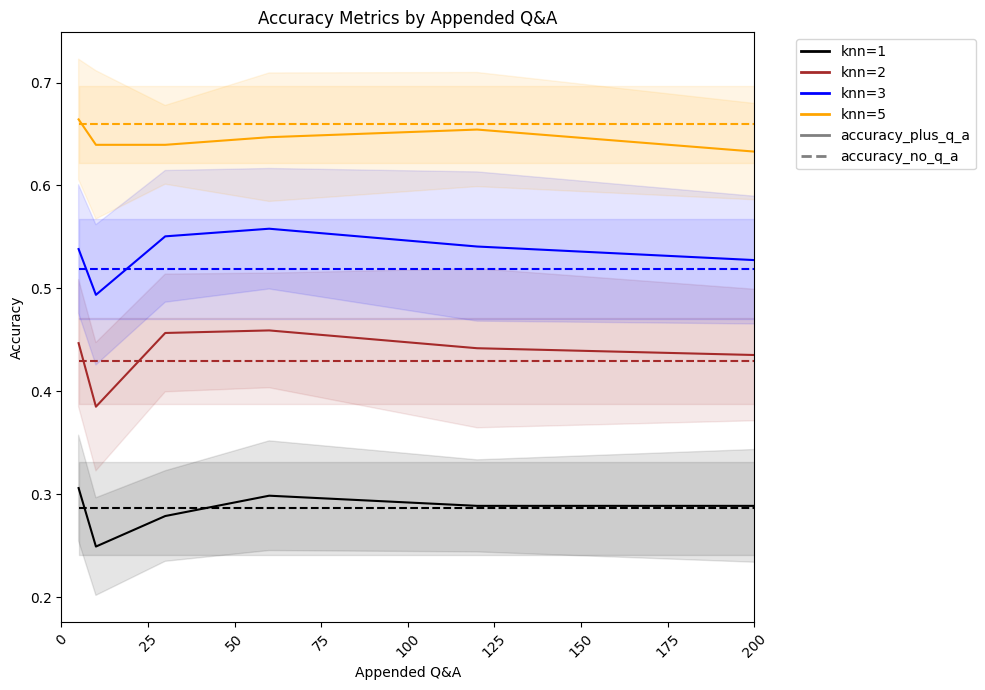

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

results_random_split_df = pd.read_csv("results/results_from_clip_v2.csv")
# Group by 'appended_q_a' and calculate mean and std
# metrics = ['argmax', 'knn=2', 'knn=3', 'knn=5', 'hungarian']
metrics = ['knn=1', 'knn=2', 'knn=3', 'knn=5', ]
# metrics = [ 'knn=2','knn=3','knn=5'  ]
agg_dict = {}
agg_metric = "mean"
for metric in metrics:
    for acc_type in ['accuracy_plus_q_a', 'accuracy_no_q_a']:
        col_name = f'{acc_type}_{metric}'
        agg_dict[col_name] = [agg_metric, 'std']

grouped = results_random_split_df.groupby('appended_q_a').agg(agg_dict)

# Flatten column names
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

# Reset index to make 'appended_q_a' a column
grouped = grouped.reset_index()

# Set up the plot
plt.figure(figsize=(10, 7))

# Define colors and line styles
# colors = {'argmax': 'blue', 'knn=2': 'green', 'knn=3': 'limegreen', 'knn=5': 'darkgreen', 'hungarian': 'red'}
colors = {'knn=1': 'black', 'knn=2': 'brown', 'knn=3': 'blue', 'knn=5': 'orange'}
linestyles = {'accuracy_plus_q_a': '-', 'accuracy_no_q_a': '--'}

# Plot each metric
for metric in metrics:
    for acc_type in ['accuracy_plus_q_a', 'accuracy_no_q_a']:
        col_name = f'{acc_type}_{metric}_{agg_metric}'
        err_col = f'{acc_type}_{metric}_std'

        x = grouped['appended_q_a']
        y = grouped[col_name]
        yerr = grouped[err_col]

        plt.plot(x, y, color=colors[metric], linestyle=linestyles[acc_type],
                 label=f'{acc_type} - {metric}')

        plt.fill_between(x, y - yerr, y + yerr, color=colors[metric], alpha=0.1)
from matplotlib.lines import Line2D

plt.xlabel('Appended Q&A')
plt.ylabel('Accuracy')
plt.title('Accuracy Metrics by Appended Q&A')

# Create custom legend for metrics (colors)
legend_elements_metrics = [Line2D([0], [0], color=color, lw=2, label=metric)
                           for metric, color in colors.items()]

# Create custom legend for accuracy types (line styles)
legend_elements_acc_type = [Line2D([0], [0], color='gray', lw=2, linestyle=linestyle, label=acc_type)
                            for acc_type, linestyle in linestyles.items()]

# Add both legend sections
plt.legend(handles=legend_elements_metrics + legend_elements_acc_type,
           bbox_to_anchor=(1.05, 1), loc='upper left',
           title='')

plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(0, 200)
plt.show()

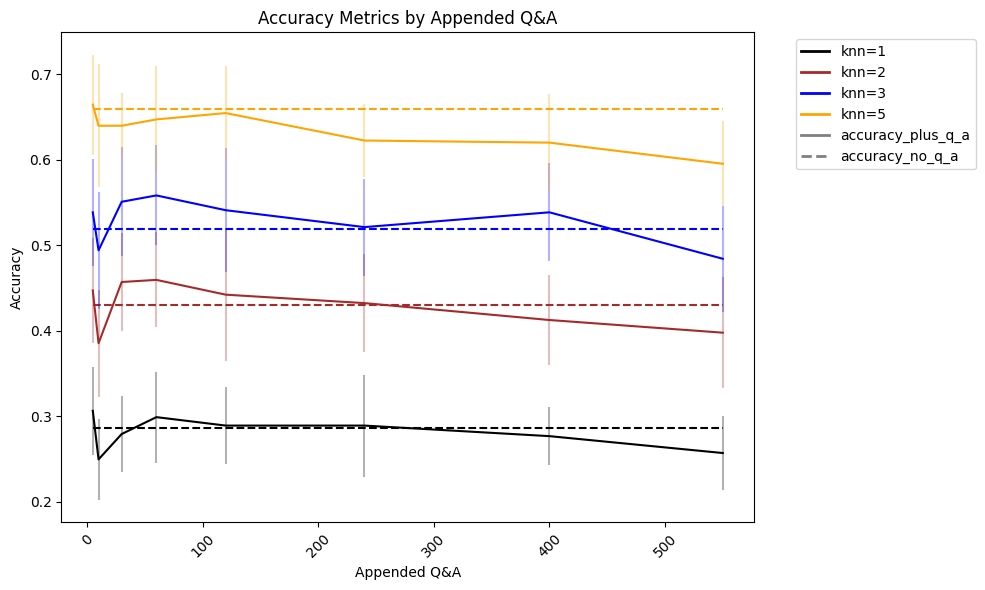

In [68]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

agg_metric = "mean"
metrics = ['knn=1', 'knn=2', 'knn=3', 'knn=5']
agg_dict = {}
for metric in metrics:
    for acc_type in ['accuracy_plus_q_a', 'accuracy_no_q_a']:
        col_name = f'{acc_type}_{metric}'
        agg_dict[col_name] = [agg_metric, 'std']

grouped = results_random_split_df.groupby('appended_q_a').agg(agg_dict)
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()

plt.figure(figsize=(10, 6))

colors = {'knn=1': 'black', 'knn=2': 'brown', 'knn=3': 'blue', 'knn=5': 'orange'}
linestyles = {'accuracy_plus_q_a': '-', 'accuracy_no_q_a': '--'}

for metric in metrics:
    for acc_type in ['accuracy_plus_q_a', 'accuracy_no_q_a']:
        col_name = f'{acc_type}_{metric}_{agg_metric}'
        err_col = f'{acc_type}_{metric}_std'

        x = grouped['appended_q_a']
        y = grouped[col_name]
        yerr = grouped[err_col]

        plt.plot(x, y, color=colors[metric], linestyle=linestyles[acc_type])

        if acc_type == 'accuracy_plus_q_a':
            plt.errorbar(x, y, yerr=yerr, color=colors[metric], fmt='none', alpha=0.3)

plt.xlabel('Appended Q&A')
plt.ylabel('Accuracy')
plt.title('Accuracy Metrics by Appended Q&A')

# Create custom legend for metrics (colors)
legend_elements_metrics = [Line2D([0], [0], color=color, lw=2, label=metric)
                           for metric, color in colors.items()]

# Create custom legend for accuracy types (line styles)
legend_elements_acc_type = [Line2D([0], [0], color='gray', lw=2, linestyle=linestyle, label=acc_type)
                            for acc_type, linestyle in linestyles.items()]

# Add both legend sections
plt.legend(handles=legend_elements_metrics + legend_elements_acc_type,
           bbox_to_anchor=(1.05, 1), loc='upper left',
           title='')

plt.xticks(rotation=45)
# plt.xlim(0,200)
plt.tight_layout()
plt.show()

/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_26143/1557327044.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['metric'] = metric
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_26143/1557327044.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['metric'] = metric
/var/folders/yv/8bscwg3x6m5934xb_mry4d_m0000gr/T/ipykernel_26143/1557327044.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

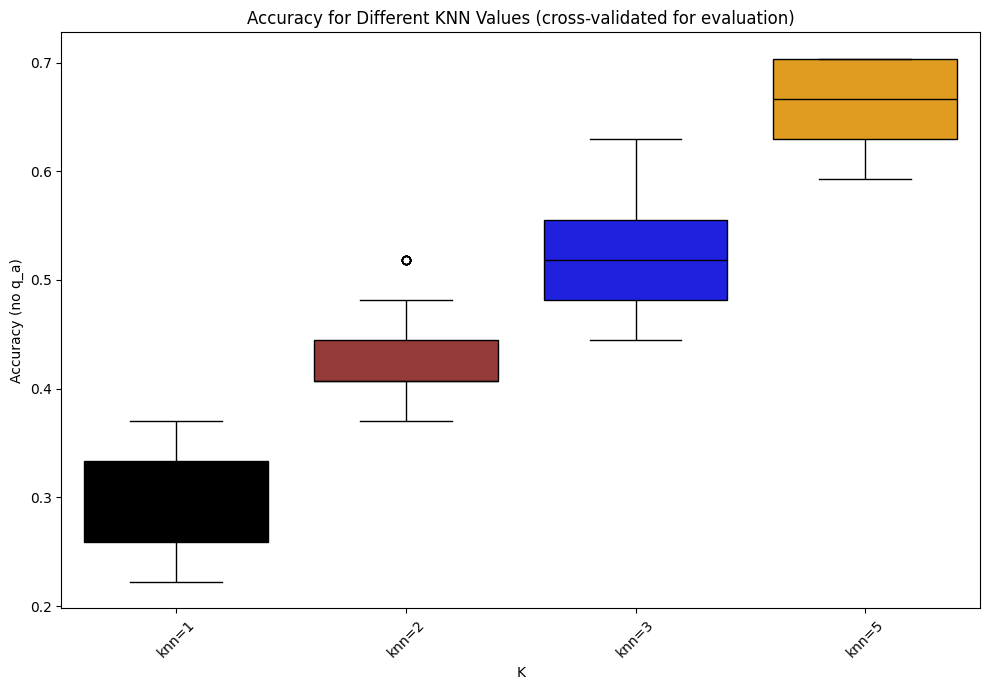

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for box plot
metrics = ['knn=1', 'knn=2', 'knn=3', 'knn=5']
plot_data = []

for metric in metrics:
    col_name = f'accuracy_no_q_a_{metric}'
    temp_df = results_random_split_df[['iter', col_name]]
    temp_df['metric'] = metric
    temp_df = temp_df.rename(columns={col_name: 'accuracy'})
    plot_data.append(temp_df)

plot_df = pd.concat(plot_data, ignore_index=True)

# Set up the plot
plt.figure(figsize=(10, 7))

# Create the box plot
sns.boxplot(x='metric', y='accuracy', data=plot_df,
            palette={'knn=1': 'black', 'knn=2': 'brown', 'knn=3': 'blue', 'knn=5': 'orange'})

# Customize the plot
plt.xlabel('K')
plt.ylabel('Accuracy (no q_a)')
plt.title('Accuracy for Different KNN Values (cross-validated for evaluation)')
plt.xticks(rotation=45)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [70]:
accuracies = plot_df.groupby("metric")["accuracy"].median().to_frame().reset_index()
accuracies["k"] = accuracies["metric"].str.split("=").str[1]
accuracies["k"] = accuracies["k"].astype(int)
accuracies["random_accuracy"] = accuracies["k"] / (df.shape[0] * 0.2)
accuracies["accuracy/random_accuracy"] = accuracies["accuracy"] / accuracies["random_accuracy"]
accuracies

,metric,accuracy,k,random_accuracy,accuracy/random_accuracy
0,knn=1,0.296296,1,0.037879,7.822222
1,knn=2,0.407407,2,0.075758,5.377778
2,knn=3,0.518519,3,0.113636,4.562963
3,knn=5,0.666667,5,0.189394,3.520000
